In [1]:
import argparse
import os
import pathlib
import shutil

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import skimage
import tifffile
import torch
import tqdm
from PIL import Image
from rich.pretty import pprint
from stardist.models import StarDist2D
from ultrack import to_tracks_layer, track, tracks_to_zarr
from ultrack.config import MainConfig
from ultrack.imgproc import normalize
from ultrack.utils import estimate_parameters_from_labels, labels_to_contours

# check if in a jupyter notebook

try:
    cfg = get_ipython().config
    in_notebook = True
except NameError:
    in_notebook = False

print(f"Running in notebook: {in_notebook}")

os.environ["OMP_NUM_THREADS"] = "8"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"


# check gpu
import tensorflow as tf

gpu_devices = tf.config.experimental.list_physical_devices("GPU")
if not gpu_devices:
    print("No GPU found")
else:
    print("GPU found")


# tensorflow clear gpu memory
def clear_gpu_memory():
    from numba import cuda

    cuda.select_device(0)
    cuda.close()


clear_gpu_memory()

2025-01-01 13:57:13.627504: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-01-01 13:57:13.627529: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-01-01 13:57:13.627535: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-01 13:57:13.631849: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Running in notebook: True
GPU found


2025-01-01 13:57:16.537902: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-01-01 13:57:16.567295: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-01-01 13:57:16.571385: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [2]:
if not in_notebook:
    print("Running as script")
    # set up arg parser
    parser = argparse.ArgumentParser(description="Segment the nuclei of a tiff image")

    parser.add_argument(
        "--input_dir_main",
        type=str,
        help="Path to the input directory containing the tiff images",
    )
    parser.add_argument(
        "--input_dir_terminal",
        type=str,
        help="Path to the input directory containing the tiff images",
    )

    args = parser.parse_args()
    input_dir_main = pathlib.Path(args.input_dir_main).resolve(strict=True)
    input_dir_terminal = pathlib.Path(args.input_dir_terminal).resolve(strict=True)
else:
    print("Running in a notebook")
    input_dir_main = pathlib.Path(
        "../../2.cellprofiler_ic_processing/illum_directory_test/20231017ChromaLive_6hr_4ch_MaxIP_C-05_F0001"
    ).resolve(strict=True)
    input_dir_terminal = pathlib.Path(
        f"../../2.cellprofiler_ic_processing/illum_directory_test/20231017ChromaLive_endpoint_w_AnnexinV_2ch_MaxIP_{str(input_dir_main).split('MaxIP_')[1]}"
    ).resolve(strict=True)

temporary_output_dir = pathlib.Path("../tmp_output").resolve()
figures_output_dir = pathlib.Path("../figures").resolve()
results_output_dir = pathlib.Path("../results").resolve()
temporary_output_dir.mkdir(exist_ok=True)
figures_output_dir.mkdir(exist_ok=True)
results_output_dir.mkdir(exist_ok=True)

Running in a notebook


In [3]:
file_extensions = {".tif", ".tiff"}
# get all the tiff files
tiff_files = list(input_dir_main.glob("*"))
tiff_files = [f for f in tiff_files if f.suffix in file_extensions]
tiff_files = sorted(tiff_files)

tiff_files_terminal = list(input_dir_terminal.glob("*"))
tiff_files_terminal = [f for f in tiff_files_terminal if f.suffix in file_extensions]
tiff_files_terminal = sorted(tiff_files_terminal)

tiff_files = tiff_files + tiff_files_terminal
tiff_files = [f for f in tiff_files if "C01" in f.name]

print(f"Found {len(tiff_files)} tiff files in the input directory")

Found 14 tiff files in the input directory


In [4]:
model = StarDist2D.from_pretrained("2D_versatile_fluo")

Found model '2D_versatile_fluo' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.479071, nms_thresh=0.3.


2025-01-01 13:57:16.820252: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-01-01 13:57:16.821515: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-01-01 13:57:16.822547: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [5]:
image_dims = tifffile.imread(tiff_files[0]).shape
timelapse_raw = np.zeros(
    (len(tiff_files), image_dims[0], image_dims[1]), dtype=np.uint16
)
timelapse_raw_visualize = np.zeros(
    (len(tiff_files), image_dims[0], image_dims[1]), dtype=np.uint16
)
stardist_labels = np.zeros(
    (len(tiff_files), image_dims[0], image_dims[1]), dtype=np.uint16
)

In [6]:
# loop over all the images
max_number_of_objects = 0
print(f"Segmenting {len(tiff_files)} images")
for image_index, image_file_path in tqdm.tqdm(enumerate(tiff_files)):
    image = tifffile.imread(image_file_path)
    timelapse_raw_visualize[image_index, :, :] = image
    image = normalize(image, gamma=1.0)
    timelapse_raw[image_index, :, :] = image

    segmented_image, _ = model.predict_instances(image)
    stardist_labels[image_index, :, :] = segmented_image
    if len(np.unique(segmented_image)) > max_number_of_objects:
        max_number_of_objects = len(np.unique(segmented_image))
# concat all the images into one array
print(stardist_labels.shape)
# get the number of unqiue labels in the labels
print(f"Found {max_number_of_objects} unique labels in the stardist labels")

Segmenting 14 images


0it [00:00, ?it/s]2025-01-01 13:57:17.696268: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8907
14it [00:06,  2.14it/s]

(14, 1900, 1900)
Found 216 unique labels in the stardist labels


In [7]:
detections = np.zeros((len(tiff_files), image_dims[0], image_dims[1]), dtype=np.uint16)
edges = np.zeros((len(tiff_files), image_dims[0], image_dims[1]), dtype=np.uint16)
for frame_index, frame in enumerate(stardist_labels):
    detections[frame_index, :, :], edges[frame_index, :, :] = labels_to_contours(frame)
print(detections.shape, edges.shape)
tifffile.imwrite(f"{temporary_output_dir}/stardist_labels.tif", stardist_labels)
tifffile.imwrite(f"{temporary_output_dir}/timelapse_raw.tif", timelapse_raw)
tifffile.imwrite(f"{temporary_output_dir}/detections.tif", detections)
tifffile.imwrite(f"{temporary_output_dir}/edges.tif", edges)

clear_gpu_memory()

Converting labels to contours: 100%|██████████| 1900/1900 [00:00<00:00, 1907.78it/s]


(14, 1900, 1900) (14, 1900, 1900)


Estimating params.: 100%|██████████| 14/14 [00:00<00:00, 58.62it/s]


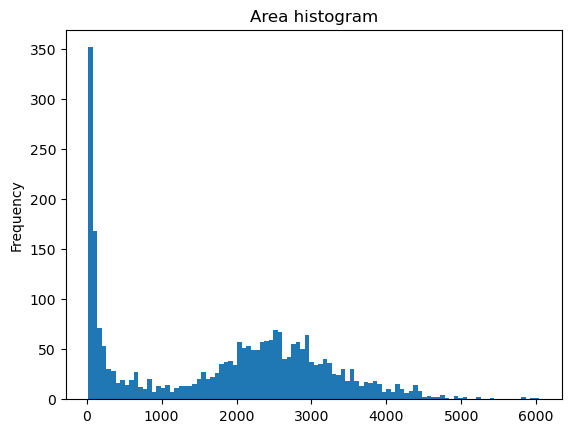

In [8]:
params_df = estimate_parameters_from_labels(stardist_labels, is_timelapse=True)
if in_notebook:
    params_df["area"].plot(kind="hist", bins=100, title="Area histogram")

## Optimize the tracking using optuna and ultrack

In [9]:
import optuna

In [10]:
config = MainConfig()
pprint(config.dict())

{
│   'data_config': {'n_workers': 1, 'working_dir': '.', 'database': 'sqlite', 'address': None},
│   'segmentation_config': {
│   │   'min_area': 100,
│   │   'max_area': 1000000,
│   │   'n_workers': 1,
│   │   'min_frontier': 0.0,
│   │   'threshold': 0.5,
│   │   'max_noise': 0.0,
│   │   'ws_hierarchy': 'area',
│   │   'anisotropy_penalization': 0.0
│   },
│   'linking_config': {
│   │   'max_distance': 15.0,
│   │   'n_workers': 1,
│   │   'max_neighbors': 5,
│   │   'distance_weight': 0.0,
│   │   'z_score_threshold': 5.0
│   },
│   'tracking_config': {
│   │   'solver_name': '',
│   │   'appear_weight': -0.001,
│   │   'disappear_weight': -0.001,
│   │   'division_weight': -0.001,
│   │   'n_threads': -1,
│   │   'window_size': None,
│   │   'overlap_size': 1,
│   │   'solution_gap': 0.001,
│   │   'time_limit': 36000,
│   │   'method': 0,
│   │   'link_function': 'power',
│   │   'power': 4,
│   │   'bias': -0.0,
│   │   'dismiss_weight_guess': None,
│   │   'include_weight_guess': None
│   }
}

In [ ]:
# set up the optuna study
study = optuna.create_study(
    study_name="cell_tracking",
    storage=f"sqlite:///{results_output_dir}/stardist.db",
    load_if_exists=True,
    direction="minimize",
)


# set up the objective function
def objective(trial):
    # get the parameters

    min_area = trial.suggest_int("min_area", 10, 49)
    max_area = trial.suggest_int("max_area", 50, 100)
    threshold = trial.suggest_float("threshold", 0.1, 0.9)

    max_distance = trial.suggest_int("max_distance", 5, 50)
    max_neighbors = trial.suggest_int("max_neighbors", 1, 25)
    z_score_threshold = trial.suggest_float("z_score_threshold", 1, 10)

    appear_weight = trial.suggest_float("appear_weight", -0.1, 0)
    disappear_weight = trial.suggest_float("disappear_weight", -0.1, 0)
    division_weight = trial.suggest_float("division_weight", -0.1, 0)
    power = trial.suggest_int("power", 1, 10)
    bias = trial.suggest_float("bias", -0.1, 0)
    solution_gap = trial.suggest_float("solution_gap", 0.0001, 0.1)

    # set up the config
    config = MainConfig()
    config.segmentation_config.min_area = min_area
    config.segmentation_config.max_area = max_area
    config.segmentation_config.threshold = threshold

    config.linking_config.max_distance = max_distance
    config.linking_config.max_neighbors = max_neighbors
    config.linking_config.z_score_threshold = z_score_threshold

    config.tracking_config.appear_weight = appear_weight
    config.tracking_config.disappear_weight = disappear_weight
    config.tracking_config.division_weight = division_weight
    config.tracking_config.power = power
    config.tracking_config.bias = bias
    config.tracking_config.solution_gap = solution_gap
    try:
        track(
            foreground=detections,
            edges=edges,
            config=config,
            overwrite=True,
        )
    except ValueError as e:
        print(e)
        return 0
    # get the number of tracks
    tracks_df, graph = to_tracks_layer(config)
    number_of_tracks = tracks_df["track_id"].nunique()
    print(f"There {max_number_of_objects} expected tracks; found {number_of_tracks}")
    tracks_df.head()
    tracks_difference_from_psuedo_gt = np.abs(number_of_tracks - max_number_of_objects)
    return tracks_difference_from_psuedo_gt


# run the optimization
study.optimize(objective, n_trials=5)

[I 2025-01-01 13:57:40,531] Using an existing study with name 'cell_tracking' instead of creating a new one.
Linking nodes.: 100%|██████████| 13/13 [00:00<00:00, 19.06it/s]


Set parameter Username
Set parameter LicenseID to value 2602925
Academic license - for non-commercial use only - expires 2025-12-23
Using Gurobi solver
Solving ILP batch 0
Constructing ILP ...
Set parameter TimeLimit to value 36000
Solving ILP ...
Set parameter NodeLimit to value 1073741824
Set parameter SolutionLimit to value 1073741824
Set parameter IntFeasTol to value 1e-06
Set parameter Method to value 3
Set parameter MIPGap to value 6.8263363713718009e-02
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (linux64 - "Pop!_OS 22.04 LTS")

CPU model: AMD Ryzen 9 5900X 12-Core Processor, instruction set [SSE2|AVX|AVX2]
Thread count: 12 physical cores, 24 logical processors, using up to 24 threads

Optimize a model with 7245 rows, 10036 columns and 17657 nonzeros
Model fingerprint: 0x400809fe
Variable types: 0 continuous, 10036 integer (10036 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [9e-04, 9e-01]
  Bounds range     [1e+00, 1e+00]
  RHS range 

[I 2025-01-01 13:57:57,750] Trial 55 finished with value: 17.0 and parameters: {'min_area': 39, 'max_area': 61, 'threshold': 0.8704937134529909, 'max_distance': 8, 'max_neighbors': 9, 'z_score_threshold': 9.493693926274277, 'appear_weight': -0.04348503502807037, 'disappear_weight': -0.09840709507882889, 'division_weight': -0.07140470405336258, 'power': 1, 'bias': -0.09216438722246839, 'solution_gap': 0.06826336371371801}. Best is trial 46 with value: 0.0.


There 216 expected tracks; found 233


Linking nodes.: 100%|██████████| 13/13 [00:00<00:00, 76.11it/s]


Set parameter Username
Set parameter LicenseID to value 2602925
Academic license - for non-commercial use only - expires 2025-12-23
Using Gurobi solver
Solving ILP batch 0
Constructing ILP ...
Set parameter TimeLimit to value 36000


[I 2025-01-01 13:58:11,117] Trial 56 finished with value: 26.0 and parameters: {'min_area': 43, 'max_area': 66, 'threshold': 0.8046621553119916, 'max_distance': 11, 'max_neighbors': 2, 'z_score_threshold': 2.1667337540515814, 'appear_weight': -0.033734327026093004, 'disappear_weight': -0.07384523030373859, 'division_weight': -0.09608127445037282, 'power': 3, 'bias': -0.0467204922338071, 'solution_gap': 0.08224766328456128}. Best is trial 46 with value: 0.0.


Solving ILP ...
Set parameter NodeLimit to value 1073741824
Set parameter SolutionLimit to value 1073741824
Set parameter IntFeasTol to value 1e-06
Set parameter Method to value 3
Set parameter MIPGap to value 8.2247663284561276e-02
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (linux64 - "Pop!_OS 22.04 LTS")

CPU model: AMD Ryzen 9 5900X 12-Core Processor, instruction set [SSE2|AVX|AVX2]
Thread count: 12 physical cores, 24 logical processors, using up to 24 threads

Optimize a model with 7227 rows, 10274 columns and 18139 nonzeros
Model fingerprint: 0x531a67a8
Variable types: 0 continuous, 10274 integer (10274 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [6e-04, 9e-01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [0e+00, 0e+00]
Found heuristic solution: objective -0.0000000
Presolve removed 7225 rows and 10269 columns
Presolve time: 0.05s
Presolved: 2 rows, 5 columns, 7 nonzeros
Found heuristic solution: objective 116.9028698
Variable

Linking nodes.:   0%|          | 0/13 [00:00<?, ?it/s]
[I 2025-01-01 13:58:24,040] Trial 57 finished with value: 0.0 and parameters: {'min_area': 47, 'max_area': 57, 'threshold': 0.7349123213881934, 'max_distance': 5, 'max_neighbors': 6, 'z_score_threshold': 7.559926741895877, 'appear_weight': -0.011987164007477949, 'disappear_weight': -0.08488507414607453, 'division_weight': -0.07200423064760589, 'power': 3, 'bias': -0.09963949090367229, 'solution_gap': 0.09034481910596436}. Best is trial 46 with value: 0.0.


No links found for time 0. Increase `linking_config.max_distance` parameter.


Linking nodes.: 100%|██████████| 13/13 [00:00<00:00, 74.35it/s]


Set parameter Username
Set parameter LicenseID to value 2602925
Academic license - for non-commercial use only - expires 2025-12-23
Using Gurobi solver
Solving ILP batch 0
Constructing ILP ...
Set parameter TimeLimit to value 36000
Solving ILP ...
Set parameter NodeLimit to value 1073741824
Set parameter SolutionLimit to value 1073741824
Set parameter IntFeasTol to value 1e-06
Set parameter Method to value 3
Set parameter MIPGap to value 8.8718651042691818e-02
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (linux64 - "Pop!_OS 22.04 LTS")

CPU model: AMD Ryzen 9 5900X 12-Core Processor, instruction set [SSE2|AVX|AVX2]
Thread count: 12 physical cores, 24 logical processors, using up to 24 threads

Optimize a model with 7245 rows, 9889 columns and 17363 nonzeros
Model fingerprint: 0xb6166bda
Variable types: 0 continuous, 9889 integer (9889 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e-03, 7e-01]
  Bounds range     [1e+00, 1e+00]
  RHS range    

[I 2025-01-01 13:58:37,300] Trial 58 finished with value: 145.0 and parameters: {'min_area': 49, 'max_area': 56, 'threshold': 0.6990100843431997, 'max_distance': 6, 'max_neighbors': 9, 'z_score_threshold': 7.535452318248242, 'appear_weight': -0.011847745548608754, 'disappear_weight': -0.06735810954916373, 'division_weight': -0.05501395042554992, 'power': 8, 'bias': -0.09947301768145973, 'solution_gap': 0.08871865104269182}. Best is trial 46 with value: 0.0.


Done!
There 216 expected tracks; found 71


Linking nodes.: 100%|██████████| 13/13 [00:00<00:00, 72.48it/s]


Set parameter Username
Set parameter LicenseID to value 2602925
Academic license - for non-commercial use only - expires 2025-12-23
Using Gurobi solver
Solving ILP batch 0
Constructing ILP ...
Set parameter TimeLimit to value 36000


[I 2025-01-01 13:58:50,794] Trial 59 finished with value: 137.0 and parameters: {'min_area': 47, 'max_area': 72, 'threshold': 0.7312460853731132, 'max_distance': 26, 'max_neighbors': 11, 'z_score_threshold': 6.427939165261364, 'appear_weight': -0.00571170935075755, 'disappear_weight': -0.08492763248500011, 'division_weight': -0.07061933787639699, 'power': 1, 'bias': -0.038962511689975526, 'solution_gap': 0.09349854295103888}. Best is trial 46 with value: 0.0.


Solving ILP ...
Set parameter NodeLimit to value 1073741824
Set parameter SolutionLimit to value 1073741824
Set parameter IntFeasTol to value 1e-06
Set parameter Method to value 3
Set parameter MIPGap to value 9.3498542951038877e-02
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (linux64 - "Pop!_OS 22.04 LTS")

CPU model: AMD Ryzen 9 5900X 12-Core Processor, instruction set [SSE2|AVX|AVX2]
Thread count: 12 physical cores, 24 logical processors, using up to 24 threads

Optimize a model with 7203 rows, 11501 columns and 20601 nonzeros
Model fingerprint: 0xf850b482
Variable types: 0 continuous, 11501 integer (11501 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e-04, 9e-01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [0e+00, 0e+00]
Found heuristic solution: objective -0.0000000
Presolve removed 7201 rows and 11497 columns
Presolve time: 0.07s
Presolved: 2 rows, 4 columns, 6 nonzeros
Found heuristic solution: objective 518.6859776
Variable

Linking nodes.: 100%|██████████| 13/13 [00:00<00:00, 74.59it/s]


Set parameter Username
Set parameter LicenseID to value 2602925
Academic license - for non-commercial use only - expires 2025-12-23
Using Gurobi solver
Solving ILP batch 0
Constructing ILP ...
Set parameter TimeLimit to value 36000
Solving ILP ...
Set parameter NodeLimit to value 1073741824
Set parameter SolutionLimit to value 1073741824
Set parameter IntFeasTol to value 1e-06
Set parameter Method to value 3
Set parameter MIPGap to value 9.8830587040898116e-02
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (linux64 - "Pop!_OS 22.04 LTS")

CPU model: AMD Ryzen 9 5900X 12-Core Processor, instruction set [SSE2|AVX|AVX2]
Thread count: 12 physical cores, 24 logical processors, using up to 24 threads

Optimize a model with 7260 rows, 10057 columns and 17694 nonzeros
Model fingerprint: 0xcf3ce214
Variable types: 0 continuous, 10057 integer (10057 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e-03, 8e-01]
  Bounds range     [1e+00, 1e+00]
  RHS range 

[I 2025-01-01 13:59:04,093] Trial 60 finished with value: 16.0 and parameters: {'min_area': 44, 'max_area': 54, 'threshold': 0.762859495403102, 'max_distance': 8, 'max_neighbors': 8, 'z_score_threshold': 9.335134488509652, 'appear_weight': -0.05406120924482791, 'disappear_weight': -0.058521922809872444, 'division_weight': -0.08183177200113505, 'power': 2, 'bias': -0.09298645149251282, 'solution_gap': 0.09883058704089812}. Best is trial 46 with value: 0.0.


Presolve removed 7258 rows and 10053 columns
Presolve time: 0.06s
Presolved: 2 rows, 4 columns, 6 nonzeros
Found heuristic solution: objective 109.7235515
Variable types: 0 continuous, 4 integer (4 binary)

Explored 0 nodes (0 simplex iterations) in 0.06 seconds (0.01 work units)
Thread count was 24 (of 24 available processors)

Solution count 2: 109.724 -0 

Optimal solution found (tolerance 9.88e-02)
Best objective 1.097235514999e+02, best bound 1.097235514999e+02, gap 0.0000%
Saving solution ...
Done!
There 216 expected tracks; found 200


Linking nodes.:   0%|          | 0/13 [00:00<?, ?it/s]
[I 2025-01-01 13:59:16,752] Trial 61 finished with value: 0.0 and parameters: {'min_area': 41, 'max_area': 59, 'threshold': 0.8680282437483332, 'max_distance': 5, 'max_neighbors': 6, 'z_score_threshold': 7.674251894483674, 'appear_weight': -0.02067734450975785, 'disappear_weight': -0.0854183187751069, 'division_weight': -0.07039708924083704, 'power': 4, 'bias': -0.07913496227451298, 'solution_gap': 0.0858863758327921}. Best is trial 46 with value: 0.0.


No links found for time 0. Increase `linking_config.max_distance` parameter.


Linking nodes.: 100%|██████████| 13/13 [00:00<00:00, 29.61it/s]


Set parameter Username
Set parameter LicenseID to value 2602925
Academic license - for non-commercial use only - expires 2025-12-23
Using Gurobi solver
Solving ILP batch 0
Constructing ILP ...
Set parameter TimeLimit to value 36000
Solving ILP ...
Set parameter NodeLimit to value 1073741824
Set parameter SolutionLimit to value 1073741824
Set parameter IntFeasTol to value 1e-06
Set parameter Method to value 3
Set parameter MIPGap to value 8.4287701004837734e-02
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (linux64 - "Pop!_OS 22.04 LTS")

CPU model: AMD Ryzen 9 5900X 12-Core Processor, instruction set [SSE2|AVX|AVX2]
Thread count: 12 physical cores, 24 logical processors, using up to 24 threads

Optimize a model with 7242 rows, 9884 columns and 17354 nonzeros
Model fingerprint: 0x59741d43
Variable types: 0 continuous, 9884 integer (9884 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [3e-03, 9e-01]
  Bounds range     [1e+00, 1e+00]
  RHS range    

[I 2025-01-01 13:59:29,931] Trial 62 finished with value: 74.0 and parameters: {'min_area': 47, 'max_area': 60, 'threshold': 0.7910813915425492, 'max_distance': 6, 'max_neighbors': 3, 'z_score_threshold': 7.999428178673244, 'appear_weight': -0.024957521596614858, 'disappear_weight': -0.07524419604569738, 'division_weight': -0.05930146027132707, 'power': 3, 'bias': -0.02498691529784154, 'solution_gap': 0.08428770100483773}. Best is trial 46 with value: 0.0.


Done!
There 216 expected tracks; found 142


Linking nodes.:   0%|          | 0/13 [00:00<?, ?it/s]
[I 2025-01-01 13:59:42,884] Trial 63 finished with value: 0.0 and parameters: {'min_area': 45, 'max_area': 52, 'threshold': 0.8199532876405041, 'max_distance': 5, 'max_neighbors': 7, 'z_score_threshold': 5.103437166859212, 'appear_weight': -0.029026185281700277, 'disappear_weight': -0.08574225244933595, 'division_weight': -0.05116301577444267, 'power': 4, 'bias': -0.08876595155863523, 'solution_gap': 0.09082238162677375}. Best is trial 46 with value: 0.0.


No links found for time 0. Increase `linking_config.max_distance` parameter.


Linking nodes.:   0%|          | 0/13 [00:00<?, ?it/s]
[I 2025-01-01 13:59:55,746] Trial 64 finished with value: 0.0 and parameters: {'min_area': 40, 'max_area': 50, 'threshold': 0.8545437063355338, 'max_distance': 5, 'max_neighbors': 7, 'z_score_threshold': 5.261886303107236, 'appear_weight': -0.014096092612134976, 'disappear_weight': -0.08616510110851751, 'division_weight': -0.04886697487878556, 'power': 4, 'bias': -0.07849025832372737, 'solution_gap': 0.09211277609628375}. Best is trial 46 with value: 0.0.


No links found for time 0. Increase `linking_config.max_distance` parameter.


Linking nodes.:   0%|          | 0/13 [00:00<?, ?it/s]
[I 2025-01-01 14:00:08,710] Trial 65 finished with value: 0.0 and parameters: {'min_area': 36, 'max_area': 53, 'threshold': 0.8709214361959402, 'max_distance': 5, 'max_neighbors': 10, 'z_score_threshold': 4.951279556380302, 'appear_weight': -0.014950446487948379, 'disappear_weight': -0.08624804009722337, 'division_weight': -0.04912113942644845, 'power': 4, 'bias': -0.08838094837806842, 'solution_gap': 0.09103005229521673}. Best is trial 46 with value: 0.0.


No links found for time 0. Increase `linking_config.max_distance` parameter.


Linking nodes.:   0%|          | 0/13 [00:00<?, ?it/s]
[I 2025-01-01 14:00:21,677] Trial 66 finished with value: 0.0 and parameters: {'min_area': 36, 'max_area': 51, 'threshold': 0.8711890520143675, 'max_distance': 5, 'max_neighbors': 10, 'z_score_threshold': 4.8767247397535485, 'appear_weight': -0.015392395160630672, 'disappear_weight': -0.08610409782684789, 'division_weight': -0.047872979440691556, 'power': 5, 'bias': -0.07821470740198559, 'solution_gap': 0.09156496393349889}. Best is trial 46 with value: 0.0.


No links found for time 0. Increase `linking_config.max_distance` parameter.


Linking nodes.:   0%|          | 0/13 [00:00<?, ?it/s]
[I 2025-01-01 14:00:34,510] Trial 67 finished with value: 0.0 and parameters: {'min_area': 31, 'max_area': 52, 'threshold': 0.7588969811681198, 'max_distance': 5, 'max_neighbors': 13, 'z_score_threshold': 6.094487637250268, 'appear_weight': -0.008325289603338589, 'disappear_weight': -0.09914159934832295, 'division_weight': -0.03876200478020586, 'power': 4, 'bias': -0.06419094826794701, 'solution_gap': 0.08770636090143019}. Best is trial 46 with value: 0.0.


No links found for time 0. Increase `linking_config.max_distance` parameter.


Linking nodes.: 100%|██████████| 13/13 [00:00<00:00, 75.29it/s]


Set parameter Username
Set parameter LicenseID to value 2602925
Academic license - for non-commercial use only - expires 2025-12-23
Using Gurobi solver
Solving ILP batch 0
Constructing ILP ...
Set parameter TimeLimit to value 36000
Solving ILP ...
Set parameter NodeLimit to value 1073741824
Set parameter SolutionLimit to value 1073741824
Set parameter IntFeasTol to value 1e-06
Set parameter Method to value 3
Set parameter MIPGap to value 9.6218446615376083e-02
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (linux64 - "Pop!_OS 22.04 LTS")

CPU model: AMD Ryzen 9 5900X 12-Core Processor, instruction set [SSE2|AVX|AVX2]
Thread count: 12 physical cores, 24 logical processors, using up to 24 threads

Optimize a model with 7257 rows, 10055 columns and 17691 nonzeros
Model fingerprint: 0xc03b814f
Variable types: 0 continuous, 10055 integer (10055 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e-03, 7e-01]
  Bounds range     [1e+00, 1e+00]
  RHS range 

[I 2025-01-01 14:00:48,017] Trial 68 finished with value: 119.0 and parameters: {'min_area': 35, 'max_area': 57, 'threshold': 0.8139367886056073, 'max_distance': 8, 'max_neighbors': 11, 'z_score_threshold': 5.15869491510257, 'appear_weight': -0.012454028565593384, 'disappear_weight': -0.08663701822091081, 'division_weight': -0.04672891036488411, 'power': 7, 'bias': -0.08735851171030862, 'solution_gap': 0.09621844661537608}. Best is trial 46 with value: 0.0.


Presolve removed 7255 rows and 10051 columns
Presolve time: 0.04s
Presolved: 2 rows, 4 columns, 6 nonzeros
Found heuristic solution: objective 17.2452254
Variable types: 0 continuous, 4 integer (4 binary)

Explored 0 nodes (0 simplex iterations) in 0.04 seconds (0.01 work units)
Thread count was 24 (of 24 available processors)

Solution count 2: 17.2452 -0 

Optimal solution found (tolerance 9.62e-02)
Best objective 1.724522542401e+01, best bound 1.724522542401e+01, gap 0.0000%
Saving solution ...
Done!
There 216 expected tracks; found 97


Linking nodes.: 100%|██████████| 13/13 [00:00<00:00, 76.29it/s]


Set parameter Username
Set parameter LicenseID to value 2602925
Academic license - for non-commercial use only - expires 2025-12-23
Using Gurobi solver
Solving ILP batch 0
Constructing ILP ...
Set parameter TimeLimit to value 36000
Solving ILP ...
Set parameter NodeLimit to value 1073741824
Set parameter SolutionLimit to value 1073741824
Set parameter IntFeasTol to value 1e-06
Set parameter Method to value 3
Set parameter MIPGap to value 8.5658390811972074e-02
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (linux64 - "Pop!_OS 22.04 LTS")

CPU model: AMD Ryzen 9 5900X 12-Core Processor, instruction set [SSE2|AVX|AVX2]
Thread count: 12 physical cores, 24 logical processors, using up to 24 threads

Optimize a model with 7260 rows, 9984 columns and 17548 nonzeros
Model fingerprint: 0x8b940730
Variable types: 0 continuous, 9984 integer (9984 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e-03, 8e-01]
  Bounds range     [1e+00, 1e+00]
  RHS range    

[I 2025-01-01 14:01:01,549] Trial 69 finished with value: 62.0 and parameters: {'min_area': 41, 'max_area': 54, 'threshold': 0.8550834105620945, 'max_distance': 7, 'max_neighbors': 8, 'z_score_threshold': 7.5064407744404535, 'appear_weight': -0.01994246538136693, 'disappear_weight': -0.09450394708975303, 'division_weight': -0.05323435365641616, 'power': 4, 'bias': -0.0791381685320915, 'solution_gap': 0.08565839081197207}. Best is trial 46 with value: 0.0.


Presolve removed 7258 rows and 9980 columns
Presolve time: 0.03s
Presolved: 2 rows, 4 columns, 6 nonzeros
Found heuristic solution: objective 50.3280721
Variable types: 0 continuous, 4 integer (4 binary)

Explored 0 nodes (0 simplex iterations) in 0.04 seconds (0.01 work units)
Thread count was 24 (of 24 available processors)

Solution count 2: 50.3281 -0 

Optimal solution found (tolerance 8.57e-02)
Best objective 5.032807212733e+01, best bound 5.032807212733e+01, gap 0.0000%
Saving solution ...
Done!
There 216 expected tracks; found 154


Linking nodes.: 100%|██████████| 13/13 [00:00<00:00, 77.23it/s]


Set parameter Username
Set parameter LicenseID to value 2602925
Academic license - for non-commercial use only - expires 2025-12-23
Using Gurobi solver
Solving ILP batch 0
Constructing ILP ...
Set parameter TimeLimit to value 36000


[I 2025-01-01 14:01:15,114] Trial 70 finished with value: 53.0 and parameters: {'min_area': 33, 'max_area': 58, 'threshold': 0.7276982426058022, 'max_distance': 10, 'max_neighbors': 19, 'z_score_threshold': 5.365998669135834, 'appear_weight': -0.013915826505414591, 'disappear_weight': -0.08878640959640706, 'division_weight': -0.043102951400403225, 'power': 5, 'bias': -0.07276880211257657, 'solution_gap': 0.09151388675525174}. Best is trial 46 with value: 0.0.


Solving ILP ...
Set parameter NodeLimit to value 1073741824
Set parameter SolutionLimit to value 1073741824
Set parameter IntFeasTol to value 1e-06
Set parameter Method to value 3
Set parameter MIPGap to value 9.1513886755251739e-02
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (linux64 - "Pop!_OS 22.04 LTS")

CPU model: AMD Ryzen 9 5900X 12-Core Processor, instruction set [SSE2|AVX|AVX2]
Thread count: 12 physical cores, 24 logical processors, using up to 24 threads

Optimize a model with 7257 rows, 10219 columns and 18019 nonzeros
Model fingerprint: 0x914b20ad
Variable types: 0 continuous, 10219 integer (10219 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [7e-04, 8e-01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [0e+00, 0e+00]
Found heuristic solution: objective -0.0000000
Presolve removed 7255 rows and 10214 columns
Presolve time: 0.05s
Presolved: 2 rows, 5 columns, 7 nonzeros
Found heuristic solution: objective 43.7849836
Variable 

Linking nodes.:   0%|          | 0/13 [00:00<?, ?it/s]
[I 2025-01-01 14:01:28,173] Trial 71 finished with value: 0.0 and parameters: {'min_area': 37, 'max_area': 50, 'threshold': 0.8710077165654451, 'max_distance': 5, 'max_neighbors': 10, 'z_score_threshold': 6.680168505126407, 'appear_weight': -0.00034877562393947556, 'disappear_weight': -0.08379767952421127, 'division_weight': -0.0494701357199047, 'power': 5, 'bias': -0.09989768407704516, 'solution_gap': 0.09201619650050837}. Best is trial 46 with value: 0.0.


No links found for time 0. Increase `linking_config.max_distance` parameter.


Linking nodes.:   0%|          | 0/13 [00:00<?, ?it/s]
[I 2025-01-01 14:01:41,270] Trial 72 finished with value: 0.0 and parameters: {'min_area': 29, 'max_area': 52, 'threshold': 0.8925722864269925, 'max_distance': 5, 'max_neighbors': 10, 'z_score_threshold': 5.016496351934675, 'appear_weight': -0.017170870136149093, 'disappear_weight': -0.07701898206354901, 'division_weight': -0.048322947296245866, 'power': 6, 'bias': -0.07821079789582897, 'solution_gap': 0.09665340156752376}. Best is trial 46 with value: 0.0.


No links found for time 0. Increase `linking_config.max_distance` parameter.


Linking nodes.: 100%|██████████| 13/13 [00:00<00:00, 26.35it/s]


Set parameter Username
Set parameter LicenseID to value 2602925
Academic license - for non-commercial use only - expires 2025-12-23
Using Gurobi solver
Solving ILP batch 0
Constructing ILP ...
Set parameter TimeLimit to value 36000


[I 2025-01-01 14:01:54,948] Trial 73 finished with value: 30.0 and parameters: {'min_area': 39, 'max_area': 52, 'threshold': 0.8237958766617799, 'max_distance': 9, 'max_neighbors': 12, 'z_score_threshold': 4.799811213281821, 'appear_weight': -0.00908361694218298, 'disappear_weight': -0.0941946570456012, 'division_weight': -0.04029078209515593, 'power': 4, 'bias': -0.08924202303800666, 'solution_gap': 0.08154439926896637}. Best is trial 46 with value: 0.0.


Solving ILP ...
Set parameter NodeLimit to value 1073741824
Set parameter SolutionLimit to value 1073741824
Set parameter IntFeasTol to value 1e-06
Set parameter Method to value 3
Set parameter MIPGap to value 8.1544399268966367e-02
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (linux64 - "Pop!_OS 22.04 LTS")

CPU model: AMD Ryzen 9 5900X 12-Core Processor, instruction set [SSE2|AVX|AVX2]
Thread count: 12 physical cores, 24 logical processors, using up to 24 threads

Optimize a model with 7269 rows, 10170 columns and 17917 nonzeros
Model fingerprint: 0x9e67502c
Variable types: 0 continuous, 10170 integer (10170 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [2e-03, 8e-01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [0e+00, 0e+00]
Found heuristic solution: objective -0.0000000
Presolve removed 7260 rows and 10156 columns
Presolve time: 0.05s
Presolved: 9 rows, 14 columns, 26 nonzeros
Found heuristic solution: objective 57.7622850
Variabl

Linking nodes.: 100%|██████████| 13/13 [00:00<00:00, 70.08it/s]


Set parameter Username
Set parameter LicenseID to value 2602925
Academic license - for non-commercial use only - expires 2025-12-23
Using Gurobi solver
Solving ILP batch 0
Constructing ILP ...
Set parameter TimeLimit to value 36000
Solving ILP ...
Set parameter NodeLimit to value 1073741824
Set parameter SolutionLimit to value 1073741824
Set parameter IntFeasTol to value 1e-06
Set parameter Method to value 3
Set parameter MIPGap to value 9.0247449980795758e-02
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (linux64 - "Pop!_OS 22.04 LTS")

CPU model: AMD Ryzen 9 5900X 12-Core Processor, instruction set [SSE2|AVX|AVX2]
Thread count: 12 physical cores, 24 logical processors, using up to 24 threads

Optimize a model with 7272 rows, 9999 columns and 17574 nonzeros
Model fingerprint: 0x5d6ecd9f
Variable types: 0 continuous, 9999 integer (9999 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [3e-03, 8e-01]
  Bounds range     [1e+00, 1e+00]
  RHS range    

[I 2025-01-01 14:02:08,260] Trial 74 finished with value: 83.0 and parameters: {'min_area': 33, 'max_area': 54, 'threshold': 0.7784033322213176, 'max_distance': 7, 'max_neighbors': 7, 'z_score_threshold': 5.963431029331897, 'appear_weight': -0.028376306349392064, 'disappear_weight': -0.08440083674831966, 'division_weight': -0.04665345459532923, 'power': 5, 'bias': -0.0954517214934038, 'solution_gap': 0.09024744998079576}. Best is trial 46 with value: 0.0.


Presolve removed 7270 rows and 9995 columns
Presolve time: 0.03s
Presolved: 2 rows, 4 columns, 6 nonzeros
Found heuristic solution: objective 32.4471357
Variable types: 0 continuous, 4 integer (4 binary)

Explored 0 nodes (0 simplex iterations) in 0.04 seconds (0.01 work units)
Thread count was 24 (of 24 available processors)

Solution count 2: 32.4471 -0 

Optimal solution found (tolerance 9.02e-02)
Best objective 3.244713568944e+01, best bound 3.244713568944e+01, gap 0.0000%
Saving solution ...
Done!
There 216 expected tracks; found 133


Linking nodes.: 100%|██████████| 13/13 [00:00<00:00, 69.18it/s]


Set parameter Username
Set parameter LicenseID to value 2602925
Academic license - for non-commercial use only - expires 2025-12-23
Using Gurobi solver
Solving ILP batch 0
Constructing ILP ...
Set parameter TimeLimit to value 36000


[I 2025-01-01 14:02:21,509] Trial 75 finished with value: 10.0 and parameters: {'min_area': 44, 'max_area': 58, 'threshold': 0.8692605786691947, 'max_distance': 10, 'max_neighbors': 9, 'z_score_threshold': 4.527955204953823, 'appear_weight': -0.004961626798941355, 'disappear_weight': -0.0869413525011364, 'division_weight': -0.05267114244813472, 'power': 4, 'bias': -0.0752426180874291, 'solution_gap': 0.09456906289883459}. Best is trial 46 with value: 0.0.


Solving ILP ...
Set parameter NodeLimit to value 1073741824
Set parameter SolutionLimit to value 1073741824
Set parameter IntFeasTol to value 1e-06
Set parameter Method to value 3
Set parameter MIPGap to value 9.4569062898834585e-02
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (linux64 - "Pop!_OS 22.04 LTS")

CPU model: AMD Ryzen 9 5900X 12-Core Processor, instruction set [SSE2|AVX|AVX2]
Thread count: 12 physical cores, 24 logical processors, using up to 24 threads

Optimize a model with 7242 rows, 10195 columns and 17976 nonzeros
Model fingerprint: 0x78977007
Variable types: 0 continuous, 10195 integer (10195 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [7e-04, 8e-01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [0e+00, 0e+00]
Found heuristic solution: objective -0.0000000
Presolve removed 7240 rows and 10190 columns
Presolve time: 0.05s
Presolved: 2 rows, 5 columns, 7 nonzeros
Found heuristic solution: objective 67.0594442
Variable 

Linking nodes.:   0%|          | 0/13 [00:00<?, ?it/s]
[I 2025-01-01 14:02:34,231] Trial 76 finished with value: 0.0 and parameters: {'min_area': 42, 'max_area': 51, 'threshold': 0.8295195368131889, 'max_distance': 5, 'max_neighbors': 11, 'z_score_threshold': 3.982121436803154, 'appear_weight': -0.01485008683601277, 'disappear_weight': -0.09148414801907637, 'division_weight': -0.09855153731002006, 'power': 5, 'bias': -0.07831600926643918, 'solution_gap': 0.08864323765519984}. Best is trial 46 with value: 0.0.


No links found for time 0. Increase `linking_config.max_distance` parameter.


Linking nodes.: 100%|██████████| 13/13 [00:00<00:00, 73.11it/s]


Set parameter Username
Set parameter LicenseID to value 2602925
Academic license - for non-commercial use only - expires 2025-12-23
Using Gurobi solver
Solving ILP batch 0
Constructing ILP ...
Set parameter TimeLimit to value 36000
Solving ILP ...
Set parameter NodeLimit to value 1073741824
Set parameter SolutionLimit to value 1073741824
Set parameter IntFeasTol to value 1e-06
Set parameter Method to value 3
Set parameter MIPGap to value 9.9933557986655042e-02
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (linux64 - "Pop!_OS 22.04 LTS")

CPU model: AMD Ryzen 9 5900X 12-Core Processor, instruction set [SSE2|AVX|AVX2]
Thread count: 12 physical cores, 24 logical processors, using up to 24 threads

Optimize a model with 7272 rows, 10000 columns and 17576 nonzeros
Model fingerprint: 0x61379149
Variable types: 0 continuous, 10000 integer (10000 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [4e-03, 8e-01]
  Bounds range     [1e+00, 1e+00]
  RHS range 

[I 2025-01-01 14:02:47,304] Trial 77 finished with value: 63.0 and parameters: {'min_area': 35, 'max_area': 53, 'threshold': 0.8710626864975235, 'max_distance': 7, 'max_neighbors': 8, 'z_score_threshold': 5.447636531454725, 'appear_weight': -0.02229014569659169, 'disappear_weight': -0.09993568508293874, 'division_weight': -0.05827267648668556, 'power': 4, 'bias': -0.08591597352273528, 'solution_gap': 0.09993355798665504}. Best is trial 46 with value: 0.0.


Presolve removed 7270 rows and 9996 columns
Presolve time: 0.03s
Presolved: 2 rows, 4 columns, 6 nonzeros
Found heuristic solution: objective 47.7477996
Variable types: 0 continuous, 4 integer (4 binary)

Explored 0 nodes (0 simplex iterations) in 0.03 seconds (0.01 work units)
Thread count was 24 (of 24 available processors)

Solution count 2: 47.7478 -0 

Optimal solution found (tolerance 9.99e-02)
Best objective 4.774779960102e+01, best bound 4.774779960102e+01, gap 0.0000%
Saving solution ...
Done!
There 216 expected tracks; found 153


Linking nodes.: 100%|██████████| 13/13 [00:00<00:00, 74.67it/s]


Set parameter Username
Set parameter LicenseID to value 2602925
Academic license - for non-commercial use only - expires 2025-12-23
Using Gurobi solver
Solving ILP batch 0
Constructing ILP ...
Set parameter TimeLimit to value 36000
Solving ILP ...
Set parameter NodeLimit to value 1073741824
Set parameter SolutionLimit to value 1073741824
Set parameter IntFeasTol to value 1e-06
Set parameter Method to value 3
Set parameter MIPGap to value 8.5497831807204522e-02
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (linux64 - "Pop!_OS 22.04 LTS")

CPU model: AMD Ryzen 9 5900X 12-Core Processor, instruction set [SSE2|AVX|AVX2]
Thread count: 12 physical cores, 24 logical processors, using up to 24 threads

Optimize a model with 7254 rows, 10151 columns and 17884 nonzeros
Model fingerprint: 0x4b4e775b
Variable types: 0 continuous, 10151 integer (10151 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [5e-04, 8e-01]
  Bounds range     [1e+00, 1e+00]
  RHS range 

[I 2025-01-01 14:03:00,435] Trial 78 finished with value: 59.0 and parameters: {'min_area': 37, 'max_area': 56, 'threshold': 0.7957964925387085, 'max_distance': 9, 'max_neighbors': 16, 'z_score_threshold': 4.650307598178705, 'appear_weight': -0.02121263986562525, 'disappear_weight': -0.06963491967169912, 'division_weight': -0.029064203749626875, 'power': 5, 'bias': -0.09613329565455768, 'solution_gap': 0.08549783180720452}. Best is trial 46 with value: 0.0.


Presolve removed 7245 rows and 10136 columns
Presolve time: 0.04s
Presolved: 9 rows, 15 columns, 27 nonzeros
Found heuristic solution: objective 38.6115557
Variable types: 0 continuous, 15 integer (15 binary)

Explored 0 nodes (0 simplex iterations) in 0.05 seconds (0.01 work units)
Thread count was 24 (of 24 available processors)

Solution count 2: 38.6116 -0 

Optimal solution found (tolerance 8.55e-02)
Best objective 3.861155568113e+01, best bound 3.861155568113e+01, gap 0.0000%
Saving solution ...
Done!
There 216 expected tracks; found 157


Linking nodes.: 100%|██████████| 13/13 [00:00<00:00, 74.73it/s]


Set parameter Username
Set parameter LicenseID to value 2602925
Academic license - for non-commercial use only - expires 2025-12-23
Using Gurobi solver
Solving ILP batch 0
Constructing ILP ...
Set parameter TimeLimit to value 36000


[I 2025-01-01 14:03:13,935] Trial 79 finished with value: 18.0 and parameters: {'min_area': 43, 'max_area': 59, 'threshold': 0.8952903515523211, 'max_distance': 11, 'max_neighbors': 5, 'z_score_threshold': 7.446430147956441, 'appear_weight': -0.03644094721150583, 'disappear_weight': -0.08228239409862413, 'division_weight': -0.05182485472436718, 'power': 4, 'bias': -0.07292738929527064, 'solution_gap': 0.07162112465335424}. Best is trial 46 with value: 0.0.


Solving ILP ...
Set parameter NodeLimit to value 1073741824
Set parameter SolutionLimit to value 1073741824
Set parameter IntFeasTol to value 1e-06
Set parameter Method to value 3
Set parameter MIPGap to value 7.1621124653354240e-02
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (linux64 - "Pop!_OS 22.04 LTS")

CPU model: AMD Ryzen 9 5900X 12-Core Processor, instruction set [SSE2|AVX|AVX2]
Thread count: 12 physical cores, 24 logical processors, using up to 24 threads

Optimize a model with 7245 rows, 10301 columns and 18187 nonzeros
Model fingerprint: 0xc2d6367c
Variable types: 0 continuous, 10301 integer (10301 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [3e-03, 8e-01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [0e+00, 0e+00]
Found heuristic solution: objective -0.0000000
Presolve removed 7243 rows and 10296 columns
Presolve time: 0.05s
Presolved: 2 rows, 5 columns, 7 nonzeros
Found heuristic solution: objective 67.2245132
Variable 

Linking nodes.: 100%|██████████| 13/13 [00:00<00:00, 71.90it/s]


Set parameter Username
Set parameter LicenseID to value 2602925
Academic license - for non-commercial use only - expires 2025-12-23
Using Gurobi solver
Solving ILP batch 0
Constructing ILP ...
Set parameter TimeLimit to value 36000
Solving ILP ...
Set parameter NodeLimit to value 1073741824
Set parameter SolutionLimit to value 1073741824
Set parameter IntFeasTol to value 1e-06
Set parameter Method to value 3
Set parameter MIPGap to value 0.0965985191417648
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (linux64 - "Pop!_OS 22.04 LTS")

CPU model: AMD Ryzen 9 5900X 12-Core Processor, instruction set [SSE2|AVX|AVX2]
Thread count: 12 physical cores, 24 logical processors, using up to 24 threads

Optimize a model with 7245 rows, 9961 columns and 17507 nonzeros
Model fingerprint: 0x155c4c16
Variable types: 0 continuous, 9961 integer (9961 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [6e-04, 7e-01]
  Bounds range     [1e+00, 1e+00]
  RHS range        

[I 2025-01-01 14:03:27,490] Trial 80 finished with value: 105.0 and parameters: {'min_area': 39, 'max_area': 61, 'threshold': 0.6967691185396406, 'max_distance': 7, 'max_neighbors': 13, 'z_score_threshold': 8.746922045231951, 'appear_weight': -0.02655284842641581, 'disappear_weight': -0.08856634588649748, 'division_weight': -0.060664448799364085, 'power': 6, 'bias': -0.09070149947519718, 'solution_gap': 0.0965985191417648}. Best is trial 46 with value: 0.0.


Presolve removed 7243 rows and 9957 columns
Presolve time: 0.03s
Presolved: 2 rows, 4 columns, 6 nonzeros
Found heuristic solution: objective 22.3490557
Variable types: 0 continuous, 4 integer (4 binary)

Explored 0 nodes (0 simplex iterations) in 0.04 seconds (0.01 work units)
Thread count was 24 (of 24 available processors)

Solution count 2: 22.3491 -0 

Optimal solution found (tolerance 9.66e-02)
Best objective 2.234905565568e+01, best bound 2.234905565568e+01, gap 0.0000%
Saving solution ...
Done!
There 216 expected tracks; found 111


Linking nodes.:   0%|          | 0/13 [00:00<?, ?it/s]
[I 2025-01-01 14:03:40,664] Trial 81 finished with value: 0.0 and parameters: {'min_area': 31, 'max_area': 52, 'threshold': 0.7467285156066199, 'max_distance': 5, 'max_neighbors': 14, 'z_score_threshold': 6.085092588588068, 'appear_weight': -0.007400466384291319, 'disappear_weight': -0.0964675865856367, 'division_weight': -0.03955205278179571, 'power': 4, 'bias': -0.06584430301627676, 'solution_gap': 0.08784732067782873}. Best is trial 46 with value: 0.0.


No links found for time 0. Increase `linking_config.max_distance` parameter.


Linking nodes.:   0%|          | 0/13 [00:00<?, ?it/s]
[I 2025-01-01 14:03:53,724] Trial 82 finished with value: 0.0 and parameters: {'min_area': 27, 'max_area': 50, 'threshold': 0.7619846709634462, 'max_distance': 5, 'max_neighbors': 12, 'z_score_threshold': 7.920099371073571, 'appear_weight': -0.0102042310221162, 'disappear_weight': -0.08661072163998719, 'division_weight': -0.036800863149586915, 'power': 4, 'bias': -0.06253916568926678, 'solution_gap': 0.08028531965366724}. Best is trial 46 with value: 0.0.


No links found for time 0. Increase `linking_config.max_distance` parameter.


Linking nodes.: 100%|██████████| 13/13 [00:00<00:00, 73.91it/s]


Set parameter Username
Set parameter LicenseID to value 2602925
Academic license - for non-commercial use only - expires 2025-12-23
Using Gurobi solver
Solving ILP batch 0
Constructing ILP ...
Set parameter TimeLimit to value 36000
Solving ILP ...
Set parameter NodeLimit to value 1073741824
Set parameter SolutionLimit to value 1073741824
Set parameter IntFeasTol to value 1e-06
Set parameter Method to value 3
Set parameter MIPGap to value 9.0750128630410376e-02
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (linux64 - "Pop!_OS 22.04 LTS")

CPU model: AMD Ryzen 9 5900X 12-Core Processor, instruction set [SSE2|AVX|AVX2]
Thread count: 12 physical cores, 24 logical processors, using up to 24 threads

Optimize a model with 7272 rows, 10075 columns and 17726 nonzeros
Model fingerprint: 0x3138b04f
Variable types: 0 continuous, 10075 integer (10075 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [3e-03, 8e-01]
  Bounds range     [1e+00, 1e+00]
  RHS range 

[I 2025-01-01 14:04:07,285] Trial 83 finished with value: 28.0 and parameters: {'min_area': 30, 'max_area': 55, 'threshold': 0.8271178504305348, 'max_distance': 8, 'max_neighbors': 13, 'z_score_threshold': 6.940372181945208, 'appear_weight': -0.017332972716822638, 'disappear_weight': -0.09969788126776313, 'division_weight': -0.04544896909744516, 'power': 3, 'bias': -0.07990018575934682, 'solution_gap': 0.09075012863041038}. Best is trial 46 with value: 0.0.


Presolve removed 7270 rows and 10071 columns
Presolve time: 0.04s
Presolved: 2 rows, 4 columns, 6 nonzeros
Found heuristic solution: objective 78.2772565
Variable types: 0 continuous, 4 integer (4 binary)

Explored 0 nodes (0 simplex iterations) in 0.04 seconds (0.01 work units)
Thread count was 24 (of 24 available processors)

Solution count 2: 78.2773 -0 

Optimal solution found (tolerance 9.08e-02)
Best objective 7.827725648259e+01, best bound 7.827725648259e+01, gap 0.0000%
Saving solution ...
Done!
There 216 expected tracks; found 188


Linking nodes.: 100%|██████████| 13/13 [00:00<00:00, 72.12it/s]


Set parameter Username
Set parameter LicenseID to value 2602925
Academic license - for non-commercial use only - expires 2025-12-23
Using Gurobi solver
Solving ILP batch 0
Constructing ILP ...
Set parameter TimeLimit to value 36000
Solving ILP ...
Set parameter NodeLimit to value 1073741824
Set parameter SolutionLimit to value 1073741824
Set parameter IntFeasTol to value 1e-06
Set parameter Method to value 3
Set parameter MIPGap to value 8.5670399920437484e-02
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (linux64 - "Pop!_OS 22.04 LTS")

CPU model: AMD Ryzen 9 5900X 12-Core Processor, instruction set [SSE2|AVX|AVX2]
Thread count: 12 physical cores, 24 logical processors, using up to 24 threads

Optimize a model with 7272 rows, 9927 columns and 17430 nonzeros
Model fingerprint: 0xec20bab7
Variable types: 0 continuous, 9927 integer (9927 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e-03, 8e-01]
  Bounds range     [1e+00, 1e+00]
  RHS range    

[I 2025-01-01 14:04:20,427] Trial 84 finished with value: 96.0 and parameters: {'min_area': 34, 'max_area': 53, 'threshold': 0.7575091289484841, 'max_distance': 6, 'max_neighbors': 7, 'z_score_threshold': 5.691033378616477, 'appear_weight': -0.014454134564795803, 'disappear_weight': -0.09482502618266567, 'division_weight': -0.038696249510945455, 'power': 5, 'bias': -0.06329430855948741, 'solution_gap': 0.08567039992043748}. Best is trial 46 with value: 0.0.


Presolve removed 7270 rows and 9923 columns
Presolve time: 0.03s
Presolved: 2 rows, 4 columns, 6 nonzeros
Found heuristic solution: objective 34.8227759
Variable types: 0 continuous, 4 integer (4 binary)

Explored 0 nodes (0 simplex iterations) in 0.03 seconds (0.01 work units)
Thread count was 24 (of 24 available processors)

Solution count 2: 34.8228 -0 

Optimal solution found (tolerance 8.57e-02)
Best objective 3.482277588500e+01, best bound 3.482277588500e+01, gap 0.0000%
Saving solution ...
Done!
There 216 expected tracks; found 120


Linking nodes.: 100%|██████████| 13/13 [00:00<00:00, 79.30it/s]


Set parameter Username
Set parameter LicenseID to value 2602925
Academic license - for non-commercial use only - expires 2025-12-23
Using Gurobi solver
Solving ILP batch 0
Constructing ILP ...
Set parameter TimeLimit to value 36000
Solving ILP ...
Set parameter NodeLimit to value 1073741824
Set parameter SolutionLimit to value 1073741824
Set parameter IntFeasTol to value 1e-06
Set parameter Method to value 3
Set parameter MIPGap to value 0.0937893008353619
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (linux64 - "Pop!_OS 22.04 LTS")

CPU model: AMD Ryzen 9 5900X 12-Core Processor, instruction set [SSE2|AVX|AVX2]
Thread count: 12 physical cores, 24 logical processors, using up to 24 threads

Optimize a model with 7260 rows, 10156 columns and 17892 nonzeros
Model fingerprint: 0xd1f57678
Variable types: 0 continuous, 10156 integer (10156 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [2e-03, 8e-01]
  Bounds range     [1e+00, 1e+00]
  RHS range     

[I 2025-01-01 14:04:33,747] Trial 85 finished with value: 18.0 and parameters: {'min_area': 45, 'max_area': 55, 'threshold': 0.8538775859699933, 'max_distance': 9, 'max_neighbors': 18, 'z_score_threshold': 6.209812617808831, 'appear_weight': -0.003227297860572037, 'disappear_weight': -0.07870706342582809, 'division_weight': -0.06839126239646658, 'power': 4, 'bias': -0.0841806846074281, 'solution_gap': 0.0937893008353619}. Best is trial 46 with value: 0.0.


Presolve removed 7251 rows and 10142 columns
Presolve time: 0.05s
Presolved: 9 rows, 14 columns, 26 nonzeros
Found heuristic solution: objective 63.3446207
Variable types: 0 continuous, 14 integer (14 binary)

Explored 0 nodes (0 simplex iterations) in 0.05 seconds (0.01 work units)
Thread count was 24 (of 24 available processors)

Solution count 2: 63.3446 -0 

Optimal solution found (tolerance 9.38e-02)
Best objective 6.334462074936e+01, best bound 6.334462074936e+01, gap 0.0000%
Saving solution ...
Done!
There 216 expected tracks; found 198


Linking nodes.:   0%|          | 0/13 [00:00<?, ?it/s]
[I 2025-01-01 14:04:46,466] Trial 86 finished with value: 0.0 and parameters: {'min_area': 37, 'max_area': 57, 'threshold': 0.5773404696375375, 'max_distance': 5, 'max_neighbors': 10, 'z_score_threshold': 4.202278155953124, 'appear_weight': -0.006914460068202413, 'disappear_weight': -0.07501432719925279, 'division_weight': -0.044824155114299456, 'power': 3, 'bias': -0.0755978145845679, 'solution_gap': 0.0835463315948562}. Best is trial 46 with value: 0.0.


No links found for time 0. Increase `linking_config.max_distance` parameter.


Linking nodes.: 100%|██████████| 13/13 [00:00<00:00, 70.69it/s]


Set parameter Username
Set parameter LicenseID to value 2602925
Academic license - for non-commercial use only - expires 2025-12-23
Using Gurobi solver
Solving ILP batch 0
Constructing ILP ...
Set parameter TimeLimit to value 36000


[I 2025-01-01 14:04:59,950] Trial 87 finished with value: 0.0 and parameters: {'min_area': 32, 'max_area': 62, 'threshold': 0.8041855907198173, 'max_distance': 12, 'max_neighbors': 14, 'z_score_threshold': 5.192056167641993, 'appear_weight': -0.019563554315259336, 'disappear_weight': -0.09278206554645459, 'division_weight': -0.028824221453229458, 'power': 4, 'bias': -0.05447034782204443, 'solution_gap': 0.07708148444209496}. Best is trial 46 with value: 0.0.


Solving ILP ...
Set parameter NodeLimit to value 1073741824
Set parameter SolutionLimit to value 1073741824
Set parameter IntFeasTol to value 1e-06
Set parameter Method to value 3
Set parameter MIPGap to value 7.7081484442094964e-02
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (linux64 - "Pop!_OS 22.04 LTS")

CPU model: AMD Ryzen 9 5900X 12-Core Processor, instruction set [SSE2|AVX|AVX2]
Thread count: 12 physical cores, 24 logical processors, using up to 24 threads

Optimize a model with 7263 rows, 10410 columns and 18399 nonzeros
Model fingerprint: 0x8fce2a21
Variable types: 0 continuous, 10410 integer (10410 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [2e-03, 8e-01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [0e+00, 0e+00]
Found heuristic solution: objective -0.0000000
Presolve removed 7261 rows and 10405 columns
Presolve time: 0.06s
Presolved: 2 rows, 5 columns, 7 nonzeros
Found heuristic solution: objective 78.0394973
Variable 

Linking nodes.: 100%|██████████| 13/13 [00:00<00:00, 73.40it/s]


Set parameter Username
Set parameter LicenseID to value 2602925
Academic license - for non-commercial use only - expires 2025-12-23
Using Gurobi solver
Solving ILP batch 0
Constructing ILP ...
Set parameter TimeLimit to value 36000


[I 2025-01-01 14:05:13,547] Trial 88 finished with value: 94.0 and parameters: {'min_area': 40, 'max_area': 51, 'threshold': 0.8709501543982264, 'max_distance': 15, 'max_neighbors': 9, 'z_score_threshold': 6.553249985857446, 'appear_weight': -0.029971014288080522, 'disappear_weight': -0.0903379968868961, 'division_weight': -0.055706550100943886, 'power': 5, 'bias': -0.08640775104708534, 'solution_gap': 0.08752977059304887}. Best is trial 46 with value: 0.0.


Solving ILP ...
Set parameter NodeLimit to value 1073741824
Set parameter SolutionLimit to value 1073741824
Set parameter IntFeasTol to value 1e-06
Set parameter Method to value 3
Set parameter MIPGap to value 8.7529770593048867e-02
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (linux64 - "Pop!_OS 22.04 LTS")

CPU model: AMD Ryzen 9 5900X 12-Core Processor, instruction set [SSE2|AVX|AVX2]
Thread count: 12 physical cores, 24 logical processors, using up to 24 threads

Optimize a model with 7269 rows, 10709 columns and 18995 nonzeros
Model fingerprint: 0x96c0b51a
Variable types: 0 continuous, 10709 integer (10709 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e-04, 8e-01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [0e+00, 0e+00]
Found heuristic solution: objective -0.0000000
Presolve removed 7181 rows and 10554 columns
Presolve time: 0.06s
Presolved: 88 rows, 155 columns, 299 nonzeros
Found heuristic solution: objective 42.9791729
Vari

Linking nodes.: 100%|██████████| 13/13 [00:00<00:00, 72.20it/s]


Set parameter Username
Set parameter LicenseID to value 2602925
Academic license - for non-commercial use only - expires 2025-12-23
Using Gurobi solver
Solving ILP batch 0
Constructing ILP ...
Set parameter TimeLimit to value 36000
Solving ILP ...
Set parameter NodeLimit to value 1073741824
Set parameter SolutionLimit to value 1073741824
Set parameter IntFeasTol to value 1e-06
Set parameter Method to value 3
Set parameter MIPGap to value 9.2135063504243567e-02
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (linux64 - "Pop!_OS 22.04 LTS")

CPU model: AMD Ryzen 9 5900X 12-Core Processor, instruction set [SSE2|AVX|AVX2]
Thread count: 12 physical cores, 24 logical processors, using up to 24 threads

Optimize a model with 7272 rows, 10000 columns and 17576 nonzeros
Model fingerprint: 0x297708a2
Variable types: 0 continuous, 10000 integer (10000 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e-03, 8e-01]
  Bounds range     [1e+00, 1e+00]
  RHS range 

[I 2025-01-01 14:05:27,105] Trial 89 finished with value: 49.0 and parameters: {'min_area': 36, 'max_area': 53, 'threshold': 0.5147809986752806, 'max_distance': 7, 'max_neighbors': 5, 'z_score_threshold': 7.243099986050907, 'appear_weight': -0.01652904946548973, 'disappear_weight': -0.08263152626661446, 'division_weight': -0.08714203455093728, 'power': 3, 'bias': -0.07064937900119317, 'solution_gap': 0.09213506350424357}. Best is trial 46 with value: 0.0.


Presolve removed 7270 rows and 9996 columns
Presolve time: 0.04s
Presolved: 2 rows, 4 columns, 6 nonzeros
Found heuristic solution: objective 75.3345580
Variable types: 0 continuous, 4 integer (4 binary)

Explored 0 nodes (0 simplex iterations) in 0.04 seconds (0.01 work units)
Thread count was 24 (of 24 available processors)

Solution count 2: 75.3346 -0 

Optimal solution found (tolerance 9.21e-02)
Best objective 7.533455797248e+01, best bound 7.533455797248e+01, gap 0.0000%
Saving solution ...
Done!
There 216 expected tracks; found 167


Linking nodes.: 100%|██████████| 13/13 [00:00<00:00, 72.12it/s]


Set parameter Username
Set parameter LicenseID to value 2602925
Academic license - for non-commercial use only - expires 2025-12-23
Using Gurobi solver
Solving ILP batch 0
Constructing ILP ...
Set parameter TimeLimit to value 36000


[I 2025-01-01 14:05:40,859] Trial 90 finished with value: 41.0 and parameters: {'min_area': 48, 'max_area': 56, 'threshold': 0.6737068991855081, 'max_distance': 48, 'max_neighbors': 4, 'z_score_threshold': 9.063634396100143, 'appear_weight': -0.011121635307833617, 'disappear_weight': -0.08031028090440313, 'division_weight': -0.04153910027263333, 'power': 3, 'bias': -0.09704120243618074, 'solution_gap': 0.0965458022074994}. Best is trial 46 with value: 0.0.


Solving ILP ...
Set parameter NodeLimit to value 1073741824
Set parameter SolutionLimit to value 1073741824
Set parameter IntFeasTol to value 1e-06
Set parameter Method to value 3
Set parameter MIPGap to value 0.0965458022074994
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (linux64 - "Pop!_OS 22.04 LTS")

CPU model: AMD Ryzen 9 5900X 12-Core Processor, instruction set [SSE2|AVX|AVX2]
Thread count: 12 physical cores, 24 logical processors, using up to 24 threads

Optimize a model with 7245 rows, 12550 columns and 22685 nonzeros
Model fingerprint: 0x97c2f572
Variable types: 0 continuous, 12550 integer (12550 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [2e-04, 8e-01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [0e+00, 0e+00]
Found heuristic solution: objective -0.0000000
Presolve removed 7243 rows and 12545 columns
Presolve time: 0.08s
Presolved: 2 rows, 5 columns, 7 nonzeros
Found heuristic solution: objective 124.9357290
Variable typ

Linking nodes.:   0%|          | 0/13 [00:00<?, ?it/s]
[I 2025-01-01 14:05:53,650] Trial 91 finished with value: 0.0 and parameters: {'min_area': 37, 'max_area': 50, 'threshold': 0.8404210584934898, 'max_distance': 5, 'max_neighbors': 10, 'z_score_threshold': 6.684748026062728, 'appear_weight': -0.00025803339110611485, 'disappear_weight': -0.08407189407468696, 'division_weight': -0.04781579352161966, 'power': 5, 'bias': -0.09924242109171787, 'solution_gap': 0.09170431207553986}. Best is trial 46 with value: 0.0.


No links found for time 0. Increase `linking_config.max_distance` parameter.


Linking nodes.: 100%|██████████| 13/13 [00:00<00:00, 77.02it/s]


Set parameter Username
Set parameter LicenseID to value 2602925
Academic license - for non-commercial use only - expires 2025-12-23
Using Gurobi solver
Solving ILP batch 0
Constructing ILP ...
Set parameter TimeLimit to value 36000
Solving ILP ...
Set parameter NodeLimit to value 1073741824
Set parameter SolutionLimit to value 1073741824
Set parameter IntFeasTol to value 1e-06
Set parameter Method to value 3
Set parameter MIPGap to value 0.0889037586524506
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (linux64 - "Pop!_OS 22.04 LTS")

CPU model: AMD Ryzen 9 5900X 12-Core Processor, instruction set [SSE2|AVX|AVX2]
Thread count: 12 physical cores, 24 logical processors, using up to 24 threads

Optimize a model with 7275 rows, 9933 columns and 17441 nonzeros
Model fingerprint: 0x69d2e2bf
Variable types: 0 continuous, 9933 integer (9933 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [2e-03, 7e-01]
  Bounds range     [1e+00, 1e+00]
  RHS range        

[I 2025-01-01 14:06:06,655] Trial 92 finished with value: 108.0 and parameters: {'min_area': 38, 'max_area': 51, 'threshold': 0.8756480435532267, 'max_distance': 6, 'max_neighbors': 6, 'z_score_threshold': 7.76802516208885, 'appear_weight': -0.007738892245587015, 'disappear_weight': -0.08748456988847393, 'division_weight': -0.04929777997614176, 'power': 6, 'bias': -0.08996140571497564, 'solution_gap': 0.0889037586524506}. Best is trial 46 with value: 0.0.


Done!
There 216 expected tracks; found 108


Linking nodes.: 100%|██████████| 13/13 [00:00<00:00, 65.46it/s]


Set parameter Username
Set parameter LicenseID to value 2602925
Academic license - for non-commercial use only - expires 2025-12-23
Using Gurobi solver
Solving ILP batch 0
Constructing ILP ...
Set parameter TimeLimit to value 36000
Solving ILP ...
Set parameter NodeLimit to value 1073741824
Set parameter SolutionLimit to value 1073741824
Set parameter IntFeasTol to value 1e-06
Set parameter Method to value 3
Set parameter MIPGap to value 9.2952416302389873e-02
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (linux64 - "Pop!_OS 22.04 LTS")

CPU model: AMD Ryzen 9 5900X 12-Core Processor, instruction set [SSE2|AVX|AVX2]
Thread count: 12 physical cores, 24 logical processors, using up to 24 threads

Optimize a model with 7290 rows, 10101 columns and 17772 nonzeros
Model fingerprint: 0x6daa2ceb
Variable types: 0 continuous, 10101 integer (10101 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [2e-04, 8e-01]
  Bounds range     [1e+00, 1e+00]
  RHS range 

[I 2025-01-01 14:06:19,898] Trial 93 finished with value: 65.0 and parameters: {'min_area': 24, 'max_area': 50, 'threshold': 0.7720067029981386, 'max_distance': 8, 'max_neighbors': 8, 'z_score_threshold': 5.899468225873009, 'appear_weight': -0.003384837770531394, 'disappear_weight': -0.08530888583762009, 'division_weight': -0.05018636912556562, 'power': 5, 'bias': -0.09581615543912458, 'solution_gap': 0.09295241630238987}. Best is trial 46 with value: 0.0.


Presolve removed 7288 rows and 10097 columns
Presolve time: 0.04s
Presolved: 2 rows, 4 columns, 6 nonzeros
Found heuristic solution: objective 37.3851364
Variable types: 0 continuous, 4 integer (4 binary)

Explored 0 nodes (0 simplex iterations) in 0.04 seconds (0.01 work units)
Thread count was 24 (of 24 available processors)

Solution count 2: 37.3851 -0 

Optimal solution found (tolerance 9.30e-02)
Best objective 3.738513643886e+01, best bound 3.738513643886e+01, gap 0.0000%
Saving solution ...
Done!
There 216 expected tracks; found 151


Linking nodes.: 100%|██████████| 13/13 [00:00<00:00, 74.74it/s]


Set parameter Username
Set parameter LicenseID to value 2602925
Academic license - for non-commercial use only - expires 2025-12-23
Using Gurobi solver
Solving ILP batch 0
Constructing ILP ...
Set parameter TimeLimit to value 36000


[I 2025-01-01 14:06:33,514] Trial 94 finished with value: 32.0 and parameters: {'min_area': 36, 'max_area': 52, 'threshold': 0.8183228740482673, 'max_distance': 11, 'max_neighbors': 11, 'z_score_threshold': 6.727122707673669, 'appear_weight': -0.01326309539839673, 'disappear_weight': -0.09606071694886317, 'division_weight': -0.054630611624691454, 'power': 4, 'bias': -0.099360079285171, 'solution_gap': 0.09783399675999159}. Best is trial 46 with value: 0.0.


Solving ILP ...
Set parameter NodeLimit to value 1073741824
Set parameter SolutionLimit to value 1073741824
Set parameter IntFeasTol to value 1e-06
Set parameter Method to value 3
Set parameter MIPGap to value 9.7833996759991590e-02
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (linux64 - "Pop!_OS 22.04 LTS")

CPU model: AMD Ryzen 9 5900X 12-Core Processor, instruction set [SSE2|AVX|AVX2]
Thread count: 12 physical cores, 24 logical processors, using up to 24 threads

Optimize a model with 7278 rows, 10356 columns and 18286 nonzeros
Model fingerprint: 0xaaa22938
Variable types: 0 continuous, 10356 integer (10356 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [2e-03, 8e-01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [0e+00, 0e+00]
Found heuristic solution: objective -0.0000000
Presolve removed 7276 rows and 10351 columns
Presolve time: 0.05s
Presolved: 2 rows, 5 columns, 7 nonzeros
Found heuristic solution: objective 59.9922856
Variable 

Linking nodes.: 100%|██████████| 13/13 [00:00<00:00, 74.86it/s]


Set parameter Username
Set parameter LicenseID to value 2602925
Academic license - for non-commercial use only - expires 2025-12-23
Using Gurobi solver
Solving ILP batch 0
Constructing ILP ...
Set parameter TimeLimit to value 36000
Solving ILP ...
Set parameter NodeLimit to value 1073741824
Set parameter SolutionLimit to value 1073741824
Set parameter IntFeasTol to value 1e-06
Set parameter Method to value 3
Set parameter MIPGap to value 8.2390969822238341e-02
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (linux64 - "Pop!_OS 22.04 LTS")

CPU model: AMD Ryzen 9 5900X 12-Core Processor, instruction set [SSE2|AVX|AVX2]
Thread count: 12 physical cores, 24 logical processors, using up to 24 threads

Optimize a model with 7257 rows, 9905 columns and 17391 nonzeros
Model fingerprint: 0x3300eb62
Variable types: 0 continuous, 9905 integer (9905 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [3e-03, 8e-01]
  Bounds range     [1e+00, 1e+00]
  RHS range    

[I 2025-01-01 14:06:46,764] Trial 95 finished with value: 89.0 and parameters: {'min_area': 34, 'max_area': 58, 'threshold': 0.8989061763558005, 'max_distance': 6, 'max_neighbors': 7, 'z_score_threshold': 6.295467686756565, 'appear_weight': -0.009486393936536318, 'disappear_weight': -0.09142498745638447, 'division_weight': -0.03684633987051779, 'power': 4, 'bias': -0.09357714994574803, 'solution_gap': 0.08239096982223834}. Best is trial 46 with value: 0.0.


Presolve removed 7255 rows and 9901 columns
Presolve time: 0.03s
Presolved: 2 rows, 4 columns, 6 nonzeros
Found heuristic solution: objective 43.3341269
Variable types: 0 continuous, 4 integer (4 binary)

Explored 0 nodes (0 simplex iterations) in 0.03 seconds (0.01 work units)
Thread count was 24 (of 24 available processors)

Solution count 2: 43.3341 -0 

Optimal solution found (tolerance 8.24e-02)
Best objective 4.333412686034e+01, best bound 4.333412686034e+01, gap 0.0000%
Saving solution ...
Done!
There 216 expected tracks; found 127


Linking nodes.:   0%|          | 0/13 [00:00<?, ?it/s]
[I 2025-01-01 14:06:59,829] Trial 96 finished with value: 0.0 and parameters: {'min_area': 45, 'max_area': 54, 'threshold': 0.8551433752052051, 'max_distance': 5, 'max_neighbors': 25, 'z_score_threshold': 7.179050742638398, 'appear_weight': -0.0014805668208356729, 'disappear_weight': -0.09983169428025841, 'division_weight': -0.044652606277147414, 'power': 9, 'bias': -0.08245175012969443, 'solution_gap': 0.09429451341006394}. Best is trial 46 with value: 0.0.


No links found for time 0. Increase `linking_config.max_distance` parameter.


Linking nodes.: 100%|██████████| 13/13 [00:00<00:00, 69.72it/s]


Set parameter Username
Set parameter LicenseID to value 2602925
Academic license - for non-commercial use only - expires 2025-12-23
Using Gurobi solver
Solving ILP batch 0
Constructing ILP ...
Set parameter TimeLimit to value 36000
Solving ILP ...
Set parameter NodeLimit to value 1073741824
Set parameter SolutionLimit to value 1073741824
Set parameter IntFeasTol to value 1e-06
Set parameter Method to value 3
Set parameter MIPGap to value 8.7077962401885228e-02
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (linux64 - "Pop!_OS 22.04 LTS")

CPU model: AMD Ryzen 9 5900X 12-Core Processor, instruction set [SSE2|AVX|AVX2]
Thread count: 12 physical cores, 24 logical processors, using up to 24 threads

Optimize a model with 7245 rows, 9962 columns and 17509 nonzeros
Model fingerprint: 0x32b5d49f
Variable types: 0 continuous, 9962 integer (9962 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [3e-03, 8e-01]
  Bounds range     [1e+00, 1e+00]
  RHS range    

[I 2025-01-01 14:07:13,033] Trial 97 finished with value: 104.0 and parameters: {'min_area': 42, 'max_area': 56, 'threshold': 0.715992679441671, 'max_distance': 7, 'max_neighbors': 13, 'z_score_threshold': 8.5546717248256, 'appear_weight': -0.09845657786488465, 'disappear_weight': -0.08297769010040848, 'division_weight': -0.06132722137968137, 'power': 5, 'bias': -0.08845390447204331, 'solution_gap': 0.08707796240188523}. Best is trial 46 with value: 0.0.


Presolve removed 7243 rows and 9958 columns
Presolve time: 0.04s
Presolved: 2 rows, 4 columns, 6 nonzeros
Found heuristic solution: objective 25.1602231
Variable types: 0 continuous, 4 integer (4 binary)

Explored 0 nodes (0 simplex iterations) in 0.04 seconds (0.01 work units)
Thread count was 24 (of 24 available processors)

Solution count 2: 25.1602 -0 

Optimal solution found (tolerance 8.71e-02)
Best objective 2.516022309765e+01, best bound 2.516022309765e+01, gap 0.0000%
Saving solution ...
Done!
There 216 expected tracks; found 112


Linking nodes.: 100%|██████████| 13/13 [00:00<00:00, 73.79it/s]


Set parameter Username
Set parameter LicenseID to value 2602925
Academic license - for non-commercial use only - expires 2025-12-23
Using Gurobi solver
Solving ILP batch 0
Constructing ILP ...
Set parameter TimeLimit to value 36000


[I 2025-01-01 14:07:26,127] Trial 98 finished with value: 7.0 and parameters: {'min_area': 40, 'max_area': 53, 'threshold': 0.7923582614049791, 'max_distance': 9, 'max_neighbors': 9, 'z_score_threshold': 5.533231451914323, 'appear_weight': -0.019816830817827716, 'disappear_weight': -0.0766493267926641, 'division_weight': -0.030882231860607415, 'power': 3, 'bias': -0.0918601234795325, 'solution_gap': 0.08999237755000086}. Best is trial 46 with value: 0.0.


Solving ILP ...
Set parameter NodeLimit to value 1073741824
Set parameter SolutionLimit to value 1073741824
Set parameter IntFeasTol to value 1e-06
Set parameter Method to value 3
Set parameter MIPGap to value 8.9992377550000863e-02
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (linux64 - "Pop!_OS 22.04 LTS")

CPU model: AMD Ryzen 9 5900X 12-Core Processor, instruction set [SSE2|AVX|AVX2]
Thread count: 12 physical cores, 24 logical processors, using up to 24 threads

Optimize a model with 7260 rows, 10158 columns and 17896 nonzeros
Model fingerprint: 0xc368a546
Variable types: 0 continuous, 10158 integer (10158 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [4e-03, 8e-01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [0e+00, 0e+00]
Found heuristic solution: objective -0.0000000
Presolve removed 7251 rows and 10144 columns
Presolve time: 0.05s
Presolved: 9 rows, 14 columns, 26 nonzeros
Found heuristic solution: objective 87.0935156
Variabl

Linking nodes.: 100%|██████████| 13/13 [00:00<00:00, 76.71it/s]


Set parameter Username
Set parameter LicenseID to value 2602925
Academic license - for non-commercial use only - expires 2025-12-23
Using Gurobi solver
Solving ILP batch 0
Constructing ILP ...
Set parameter TimeLimit to value 36000


[I 2025-01-01 14:07:39,588] Trial 99 finished with value: 35.0 and parameters: {'min_area': 46, 'max_area': 51, 'threshold': 0.838060667699295, 'max_distance': 10, 'max_neighbors': 15, 'z_score_threshold': 4.884559603475954, 'appear_weight': -0.00587070600441165, 'disappear_weight': -0.07289102696658002, 'division_weight': -0.09166055320640315, 'power': 2, 'bias': -0.06719680667499088, 'solution_gap': 0.08023295531319458}. Best is trial 46 with value: 0.0.


Solving ILP ...
Set parameter NodeLimit to value 1073741824
Set parameter SolutionLimit to value 1073741824
Set parameter IntFeasTol to value 1e-06
Set parameter Method to value 3
Set parameter MIPGap to value 8.0232955313194576e-02
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (linux64 - "Pop!_OS 22.04 LTS")

CPU model: AMD Ryzen 9 5900X 12-Core Processor, instruction set [SSE2|AVX|AVX2]
Thread count: 12 physical cores, 24 logical processors, using up to 24 threads

Optimize a model with 7269 rows, 10238 columns and 18053 nonzeros
Model fingerprint: 0x1708403c
Variable types: 0 continuous, 10238 integer (10238 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e-03, 9e-01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [0e+00, 0e+00]
Found heuristic solution: objective -0.0000000
Presolve removed 7267 rows and 10233 columns
Presolve time: 0.06s
Presolved: 2 rows, 5 columns, 7 nonzeros
Found heuristic solution: objective 153.3071520
Variable

Linking nodes.: 100%|██████████| 13/13 [00:00<00:00, 79.19it/s]


Set parameter Username
Set parameter LicenseID to value 2602925
Academic license - for non-commercial use only - expires 2025-12-23
Using Gurobi solver
Solving ILP batch 0
Constructing ILP ...
Set parameter TimeLimit to value 36000


[I 2025-01-01 14:07:53,198] Trial 100 finished with value: 85.0 and parameters: {'min_area': 44, 'max_area': 59, 'threshold': 0.8793393671459145, 'max_distance': 6, 'max_neighbors': 10, 'z_score_threshold': 5.341197796325167, 'appear_weight': -0.025925572139125226, 'disappear_weight': -0.08882955338351808, 'division_weight': -0.05003366339951864, 'power': 4, 'bias': -0.04989911637630947, 'solution_gap': 0.07403700112764258}. Best is trial 46 with value: 0.0.


Solving ILP ...
Set parameter NodeLimit to value 1073741824
Set parameter SolutionLimit to value 1073741824
Set parameter IntFeasTol to value 1e-06
Set parameter Method to value 3
Set parameter MIPGap to value 7.4037001127642582e-02
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (linux64 - "Pop!_OS 22.04 LTS")

CPU model: AMD Ryzen 9 5900X 12-Core Processor, instruction set [SSE2|AVX|AVX2]
Thread count: 12 physical cores, 24 logical processors, using up to 24 threads

Optimize a model with 7245 rows, 9888 columns and 17361 nonzeros
Model fingerprint: 0x52442f26
Variable types: 0 continuous, 9888 integer (9888 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [2e-03, 8e-01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [0e+00, 0e+00]
Found heuristic solution: objective -0.0000000
Presolve removed 7243 rows and 9884 columns
Presolve time: 0.03s
Presolved: 2 rows, 4 columns, 6 nonzeros
Found heuristic solution: objective 48.8112599
Variable type

Linking nodes.:   0%|          | 0/13 [00:00<?, ?it/s]
[I 2025-01-01 14:08:06,279] Trial 101 finished with value: 0.0 and parameters: {'min_area': 30, 'max_area': 52, 'threshold': 0.8593248629303508, 'max_distance': 5, 'max_neighbors': 10, 'z_score_threshold': 5.208625040136999, 'appear_weight': -0.01664270461271223, 'disappear_weight': -0.07967946479972479, 'division_weight': -0.08255073136732646, 'power': 6, 'bias': -0.07880462546938836, 'solution_gap': 0.09549421970518288}. Best is trial 46 with value: 0.0.


No links found for time 0. Increase `linking_config.max_distance` parameter.


Linking nodes.: 100%|██████████| 13/13 [00:00<00:00, 73.50it/s]


Set parameter Username
Set parameter LicenseID to value 2602925
Academic license - for non-commercial use only - expires 2025-12-23
Using Gurobi solver
Solving ILP batch 0
Constructing ILP ...
Set parameter TimeLimit to value 36000
Solving ILP ...
Set parameter NodeLimit to value 1073741824
Set parameter SolutionLimit to value 1073741824
Set parameter IntFeasTol to value 1e-06
Set parameter Method to value 3
Set parameter MIPGap to value 9.8112984114749530e-02
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (linux64 - "Pop!_OS 22.04 LTS")

CPU model: AMD Ryzen 9 5900X 12-Core Processor, instruction set [SSE2|AVX|AVX2]
Thread count: 12 physical cores, 24 logical processors, using up to 24 threads

Optimize a model with 7272 rows, 10075 columns and 17726 nonzeros
Model fingerprint: 0x5aa6fcba
Variable types: 0 continuous, 10075 integer (10075 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e-04, 7e-01]
  Bounds range     [1e+00, 1e+00]
  RHS range 

[I 2025-01-01 14:08:19,979] Trial 102 finished with value: 113.0 and parameters: {'min_area': 29, 'max_area': 55, 'threshold': 0.8859380471157436, 'max_distance': 8, 'max_neighbors': 11, 'z_score_threshold': 5.041682659021427, 'appear_weight': -0.017697347583855095, 'disappear_weight': -0.07643209650278017, 'division_weight': -0.04798432068349019, 'power': 7, 'bias': -0.08390109339970779, 'solution_gap': 0.09811298411474953}. Best is trial 46 with value: 0.0.


Presolve removed 7270 rows and 10071 columns
Presolve time: 0.04s
Presolved: 2 rows, 4 columns, 6 nonzeros
Found heuristic solution: objective 18.2540533
Variable types: 0 continuous, 4 integer (4 binary)

Explored 0 nodes (0 simplex iterations) in 0.04 seconds (0.01 work units)
Thread count was 24 (of 24 available processors)

Solution count 2: 18.2541 -0 

Optimal solution found (tolerance 9.81e-02)
Best objective 1.825405325629e+01, best bound 1.825405325629e+01, gap 0.0000%
Saving solution ...
Done!
There 216 expected tracks; found 103


Linking nodes.:   0%|          | 0/13 [00:00<?, ?it/s]
[I 2025-01-01 14:08:33,178] Trial 103 finished with value: 0.0 and parameters: {'min_area': 28, 'max_area': 50, 'threshold': 0.8191243173548673, 'max_distance': 5, 'max_neighbors': 8, 'z_score_threshold': 8.276773614417472, 'appear_weight': -0.02366580451779942, 'disappear_weight': -0.07821642441030974, 'division_weight': -0.057209430290609736, 'power': 6, 'bias': -0.07603051412437488, 'solution_gap': 0.09181609704753756}. Best is trial 46 with value: 0.0.


No links found for time 0. Increase `linking_config.max_distance` parameter.


Linking nodes.: 100%|██████████| 13/13 [00:00<00:00, 73.86it/s]


Set parameter Username
Set parameter LicenseID to value 2602925
Academic license - for non-commercial use only - expires 2025-12-23
Using Gurobi solver
Solving ILP batch 0
Constructing ILP ...
Set parameter TimeLimit to value 36000
Solving ILP ...
Set parameter NodeLimit to value 1073741824
Set parameter SolutionLimit to value 1073741824
Set parameter IntFeasTol to value 1e-06
Set parameter Method to value 3
Set parameter MIPGap to value 8.4583396301664435e-02
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (linux64 - "Pop!_OS 22.04 LTS")

CPU model: AMD Ryzen 9 5900X 12-Core Processor, instruction set [SSE2|AVX|AVX2]
Thread count: 12 physical cores, 24 logical processors, using up to 24 threads

Optimize a model with 7278 rows, 9935 columns and 17444 nonzeros
Model fingerprint: 0x0e341745
Variable types: 0 continuous, 9935 integer (9935 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e-03, 7e-01]
  Bounds range     [1e+00, 1e+00]
  RHS range    

[I 2025-01-01 14:08:46,681] Trial 104 finished with value: 113.0 and parameters: {'min_area': 32, 'max_area': 52, 'threshold': 0.8380095170456979, 'max_distance': 6, 'max_neighbors': 7, 'z_score_threshold': 5.776631638229775, 'appear_weight': -0.012993171581418828, 'disappear_weight': -0.09274730027605337, 'division_weight': -0.052129474612821074, 'power': 6, 'bias': -0.0938253945641822, 'solution_gap': 0.08458339630166443}. Best is trial 46 with value: 0.0.


Presolve removed 7276 rows and 9931 columns
Presolve time: 0.03s
Presolved: 2 rows, 4 columns, 6 nonzeros
Found heuristic solution: objective 21.3291819
Variable types: 0 continuous, 4 integer (4 binary)

Explored 0 nodes (0 simplex iterations) in 0.03 seconds (0.01 work units)
Thread count was 24 (of 24 available processors)

Solution count 2: 21.3292 -0 

Optimal solution found (tolerance 8.46e-02)
Best objective 2.132918193410e+01, best bound 2.132918193410e+01, gap 0.0000%
Saving solution ...
Done!
There 216 expected tracks; found 103


In [12]:
# get the best parameters
best_params = study.best_params
print(f"Best parameters: {best_params}")
study.best_value

Best parameters: {'min_area': 47, 'max_area': 63, 'threshold': 0.7963514754398565, 'max_distance': 10, 'max_neighbors': 10, 'z_score_threshold': 1.0827390744345864, 'appear_weight': -0.02387615480547004, 'disappear_weight': -0.08968042470353998, 'division_weight': -0.09055358964982353, 'power': 3, 'bias': -0.09783196859688195, 'solution_gap': 0.09351265123123258}


0.0

In [13]:
# set up the config with the best parameters
config = MainConfig()
config.segmentation_config.min_area = best_params["min_area"]
config.segmentation_config.max_area = best_params["max_area"]
config.segmentation_config.threshold = best_params["threshold"]

config.linking_config.max_distance = best_params["max_distance"]
config.linking_config.max_neighbors = best_params["max_neighbors"]
config.linking_config.z_score_threshold = best_params["z_score_threshold"]

config.tracking_config.appear_weight = best_params["appear_weight"]
config.tracking_config.disappear_weight = best_params["disappear_weight"]
config.tracking_config.division_weight = best_params["division_weight"]
config.tracking_config.power = best_params["power"]
config.tracking_config.bias = best_params["bias"]
config.tracking_config.solution_gap = best_params["solution_gap"]
pprint(config.dict())
# write the config to a file for reference later
with open(f"{results_output_dir}/ultrack_config.json", "w") as f:
    f.write(config.json())

{
│   'data_config': {'n_workers': 1, 'working_dir': '.', 'database': 'sqlite', 'address': None},
│   'segmentation_config': {
│   │   'min_area': 47,
│   │   'max_area': 63,
│   │   'n_workers': 1,
│   │   'min_frontier': 0.0,
│   │   'threshold': 0.7963514754398565,
│   │   'max_noise': 0.0,
│   │   'ws_hierarchy': 'area',
│   │   'anisotropy_penalization': 0.0
│   },
│   'linking_config': {
│   │   'max_distance': 10,
│   │   'n_workers': 1,
│   │   'max_neighbors': 10,
│   │   'distance_weight': 0.0,
│   │   'z_score_threshold': 1.0827390744345864
│   },
│   'tracking_config': {
│   │   'solver_name': '',
│   │   'appear_weight': -0.02387615480547004,
│   │   'disappear_weight': -0.08968042470353998,
│   │   'division_weight': -0.09055358964982353,
│   │   'n_threads': -1,
│   │   'window_size': None,
│   │   'overlap_size': 1,
│   │   'solution_gap': 0.09351265123123258,
│   │   'time_limit': 36000,
│   │   'method': 0,
│   │   'link_function': 'power',
│   │   'power': 3,
│   │   'bias': -0.09783196859688195,
│   │   'dismiss_weight_guess': None,
│   │   'include_weight_guess': None
│   }
}

In [14]:
track(
    foreground=detections,
    edges=edges,
    config=config,
    overwrite=True,
)

Linking nodes.: 100%|██████████| 13/13 [00:00<00:00, 78.38it/s]


Set parameter Username
Set parameter LicenseID to value 2602925
Academic license - for non-commercial use only - expires 2025-12-23
Using Gurobi solver
Solving ILP batch 0
Constructing ILP ...
Set parameter TimeLimit to value 36000
Solving ILP ...
Set parameter NodeLimit to value 1073741824
Set parameter SolutionLimit to value 1073741824
Set parameter IntFeasTol to value 1e-06
Set parameter Method to value 3
Set parameter MIPGap to value 9.3512651231232577e-02
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (linux64 - "Pop!_OS 22.04 LTS")

CPU model: AMD Ryzen 9 5900X 12-Core Processor, instruction set [SSE2|AVX|AVX2]
Thread count: 12 physical cores, 24 logical processors, using up to 24 threads

Optimize a model with 7233 rows, 10182 columns and 17953 nonzeros
Model fingerprint: 0xd50f5bdc
Variable types: 0 continuous, 10182 integer (10182 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [6e-03, 8e-01]
  Bounds range     [1e+00, 1e+00]
  RHS range 

In [15]:
tracks_df, graph = to_tracks_layer(config)
labels = tracks_to_zarr(config, tracks_df)
tracks_df.to_parquet(
    f"{results_output_dir}/{str(input_dir_main).split('MaxIP_')[1]}_tracks.parquet"
)
print(tracks_df["track_id"].nunique())
print(
    f"There {max_number_of_objects} expected tracks; found {tracks_df['track_id'].nunique()}"
)
tracks_df.head()

Exporting segmentation masks: 100%|██████████| 14/14 [00:00<00:00, 112.85it/s]

217
There 216 expected tracks; found 217


,track_id,t,y,x,id,parent_track_id,parent_id
id,,,,,,,
2000004,1,1,18.0,1663.0,2000004,-1,-1
3000005,1,2,16.0,1667.0,3000005,-1,2000004
2000007,2,1,34.0,755.0,2000007,-1,-1
3000008,2,2,37.0,754.0,3000008,-1,2000007
4000008,2,3,43.0,753.0,4000008,-1,3000008


In [16]:
# save the tracks as parquet
tracks_df.reset_index(drop=True, inplace=True)
tracks = np.zeros((len(tiff_files), image_dims[0], image_dims[1]), dtype=np.uint16)
cum_tracks_df = tracks_df.copy()
timepoints = tracks_df["t"].unique()

# zero out the track_df
cum_tracks_df = cum_tracks_df.loc[cum_tracks_df["t"] == -1]

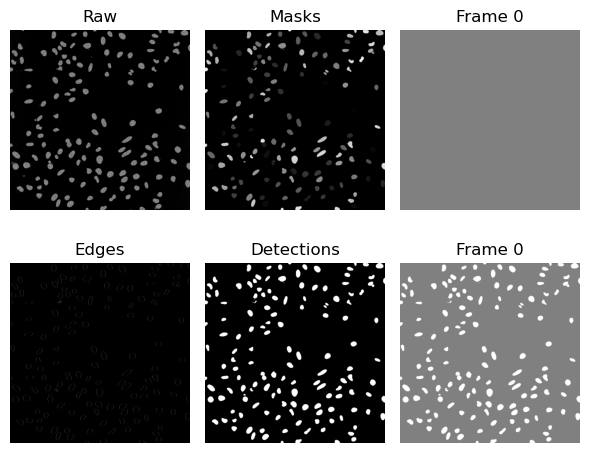

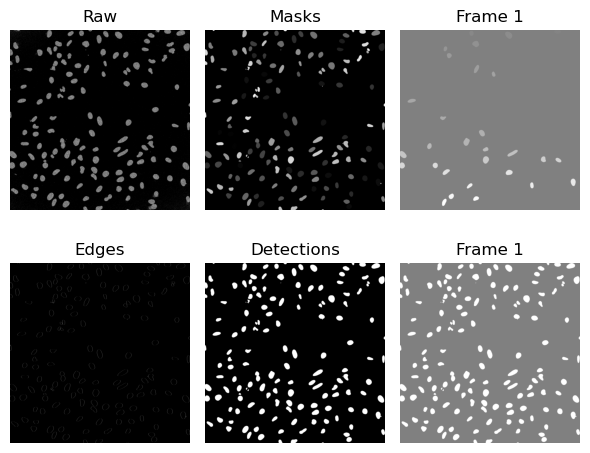

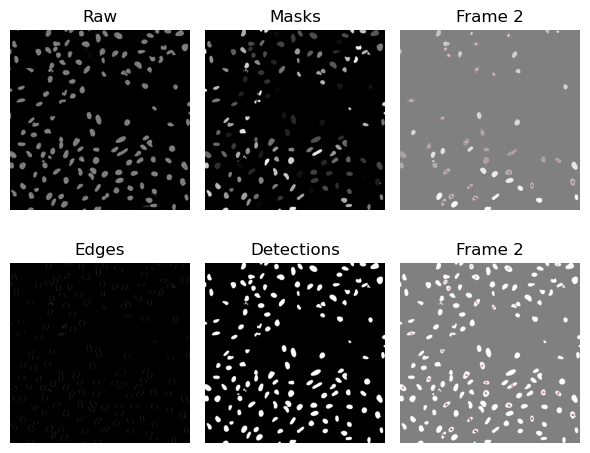

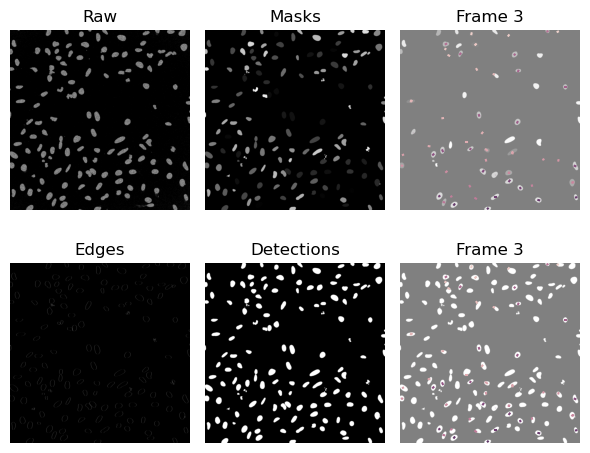

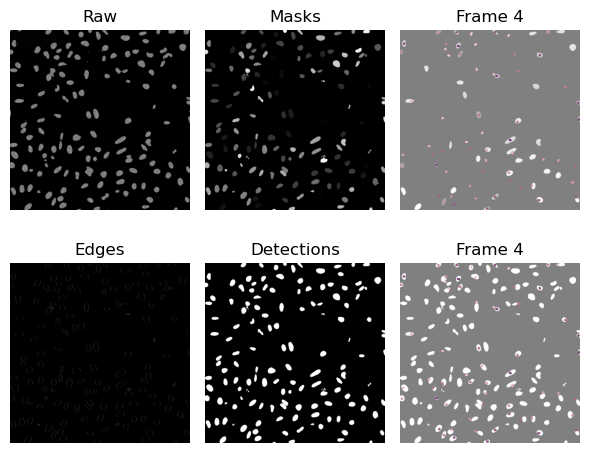

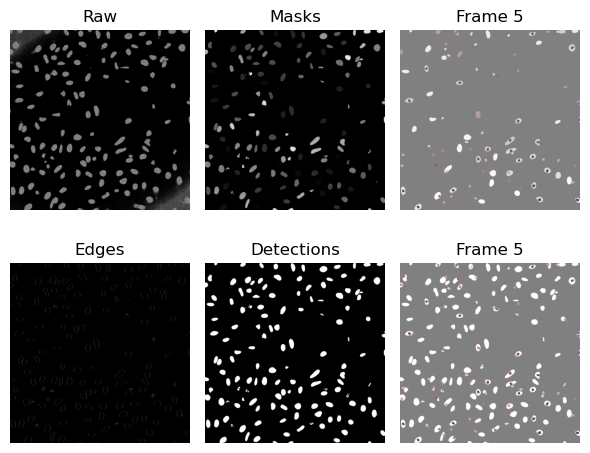

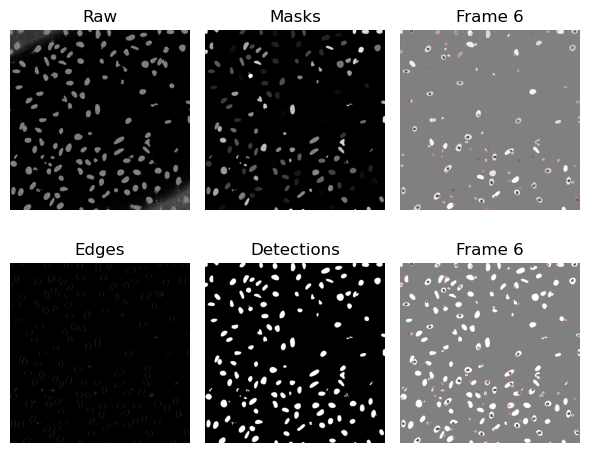

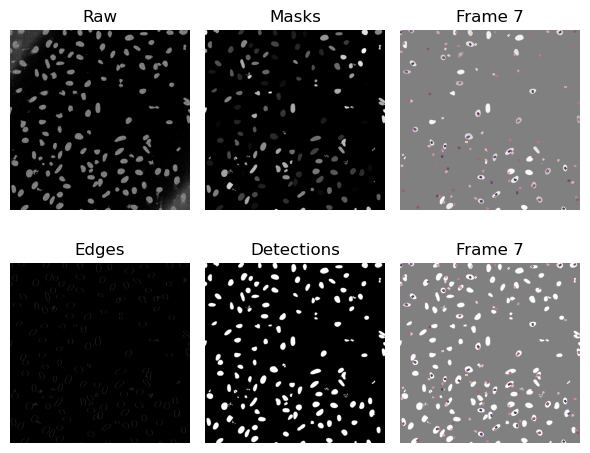

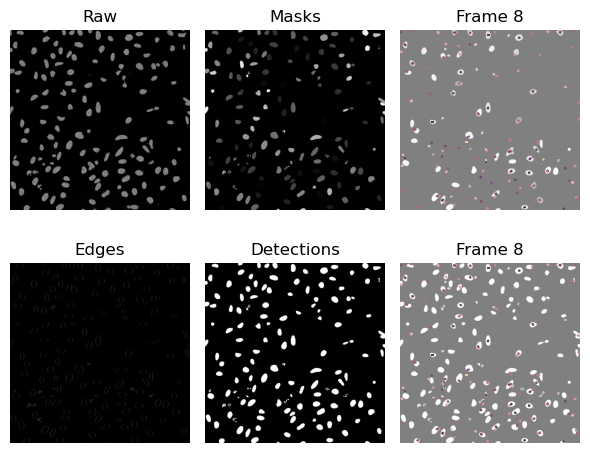

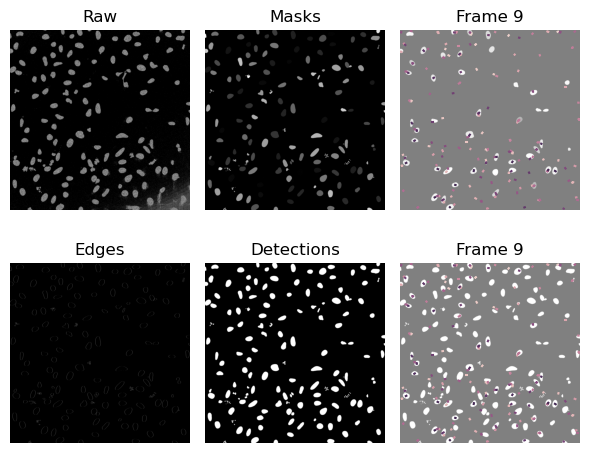

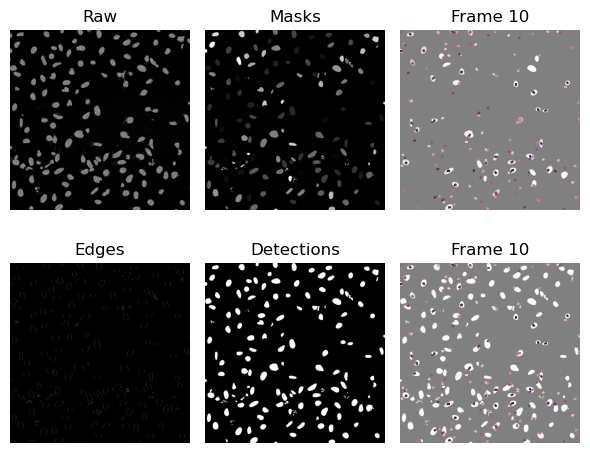

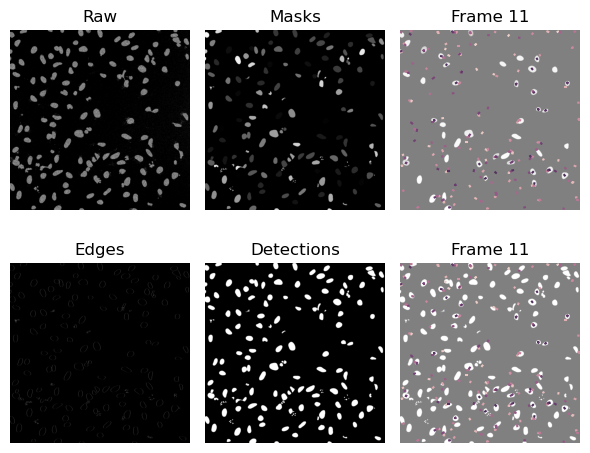

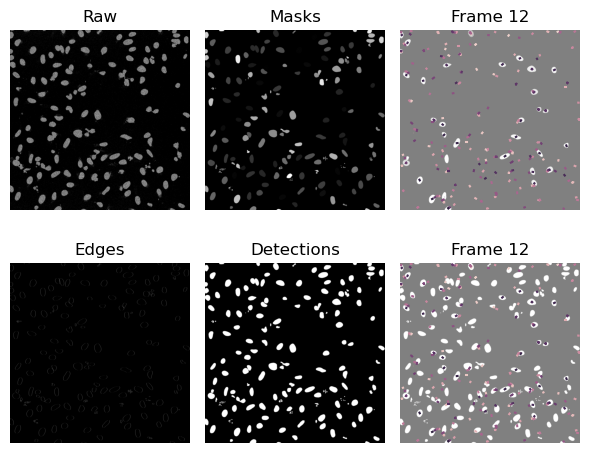

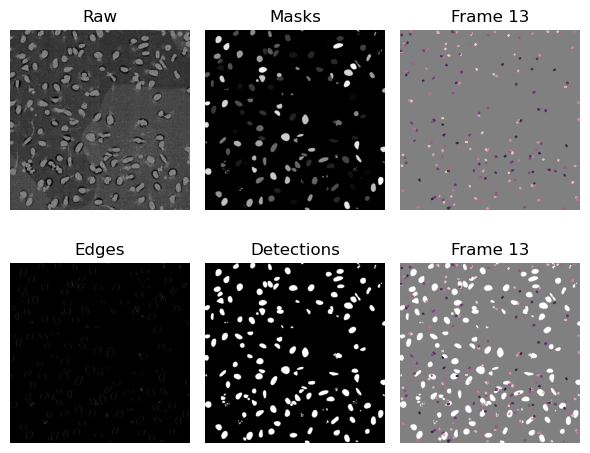

In [17]:
if in_notebook:
    for frame_index, _ in enumerate(timelapse_raw):
        tmp_df = tracks_df.loc[tracks_df["t"] == frame_index]
        cum_tracks_df = pd.concat([cum_tracks_df, tmp_df])
        plt.figure(figsize=(6, 5))
        plt.subplot(2, 3, 1)
        # rescale tbe intensity of the raw image
        raw_image = timelapse_raw_visualize[frame_index, :, :]
        raw_image = raw_image * 4096
        plt.imshow(raw_image, cmap="gray")
        plt.title("Raw")
        plt.axis("off")

        plt.subplot(2, 3, 2)
        plt.imshow(stardist_labels[frame_index, :, :], cmap="gray")
        plt.title("Masks")
        plt.axis("off")

        plt.subplot(2, 3, 3)
        sns.lineplot(data=cum_tracks_df, x="x", y="y", hue="track_id", legend=False)
        plt.imshow(labels[frame_index, :, :], cmap="gray", alpha=0.5)
        plt.title(f"Frame {frame_index}")
        plt.axis("off")

        plt.subplot(2, 3, 4)
        edge_image = skimage.exposure.adjust_gamma(
            edges[frame_index, :, :], gamma=0.0001
        )
        # make the outline brighter
        edge_image = edge_image * 1000
        plt.imshow(edge_image, cmap="gray")
        plt.title("Edges")
        plt.axis("off")

        plt.subplot(2, 3, 5)
        plt.imshow(detections[frame_index, :, :], cmap="gray")
        plt.title("Detections")
        plt.axis("off")

        plt.subplot(2, 3, 6)
        sns.lineplot(data=cum_tracks_df, x="x", y="y", hue="track_id", legend=False)
        plt.imshow(detections[frame_index, :, :], cmap="gray", alpha=0.5)
        plt.title(f"Frame {frame_index}")
        plt.axis("off")

        plt.tight_layout()
        plt.savefig(f"{temporary_output_dir}/tracks_{frame_index}.png")
    if in_notebook:
        plt.show()

In [18]:
# load each image
files = [f for f in temporary_output_dir.glob("*.png")]
files = sorted(files, key=lambda x: int(x.stem.split("_")[1]))
frames = [Image.open(f) for f in files]
fig_path = figures_output_dir / f"{str(input_dir_main).split('MaxIP_')[1]}_tracks.gif"
# plot the line of each track in matplotlib over a gif
# get the tracks
# save the frames as a gif
frames[0].save(fig_path, save_all=True, append_images=frames[1:], duration=3, loop=0)

In [19]:
# clean up tracking files
# remvoe temporary_output_dir
shutil.rmtree(temporary_output_dir)

track_db_path = pathlib.Path("data.db").resolve()
metadata_toml_path = pathlib.Path("metadata.toml").resolve()
if track_db_path.exists():
    track_db_path.unlink()
if metadata_toml_path.exists():
    metadata_toml_path.unlink()

In [20]:
clear_gpu_memory()